### Import List:

In [62]:
from time import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import pandas as pd 
import matplotlib.pyplot as plt
import os
import numpy as np
import glob
import shutil
import warnings
from sklearn.decomposition import NMF
from scipy import linalg
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from sklearn import decomposition
from gutenberg.cleanup import strip_headers
from sklearn import decomposition
import fbpca
warnings.filterwarnings("ignore")
import collections
import re
import matplotlib.pyplot as pl
from wordcloud import WordCloud

# Gutenberg Dataset:
## Load Children's Books Dataset

This dataset comes from the Gutenberg Project, the online library of free ebooks. There are 3 bookshelves related to chidlren's books: children's picture books, children's instructional books, and children's myths, fairy tales, etc. I chose to create a dataset based on the top (most popular) books from each of the bookshelves. There are a total of 120 books in the dataset.

In [2]:
# Load children's book dataset

childrens_books = os.listdir()
print(childrens_books)

['pg14407.txt', 'pg14375.txt', '12655-0.txt', 'pg24473.txt', 'pg15137.txt', 'pg12116.txt', '52521-0.txt', 'pg20748.txt', 'pg24248.txt', 'pg14837.txt', 'pg15281.txt', 'pg582.txt', 'pg15040.txt', 'pg19068.txt', 'pg21078.txt', 'pg14766.txt', 'pg22766.txt', 'pg29021.txt', 'pg24263.txt', 'pg18767.txt', '22373-0.txt', 'pg15284.txt', 'pg15521.txt', 'pg11592.txt', '.DS_Store', 'pg24676.txt', 'pg17135.txt', 'pg13347.txt', 'pg24714.txt', 'pg19734.txt', 'pg9963.txt', 'pg24852.txt', 'pg19721.txt', 'pg22600.txt', 'pg19381.txt', 'Untitled.ipynb', 'pg3031.txt', 'pg14868.txt', 'pg13650.txt', 'pg17807.txt', 'pg11319.txt', '2892-0.txt', '5110-0.txt', '16663-0.txt', '1825-0.txt', 'pg14880.txt', '2441-0.txt', 'pg18674.txt', 'pg17208.txt', '677-0.txt', 'pg22886.txt', 'pg10607.txt', '24811-0.txt', 'pg22925.txt', '25502-0.txt', 'pg1597.txt', 'pg14874.txt', 'pg7841.txt', '7128-0.txt', 'pg18525.txt', '8675-0.txt', 'pg16865.txt', 'pg7074.txt', 'pg1363.txt', '500-0.txt', 'pg1362.txt', 'pg22096.txt', 'pg3005.txt'

### Gather the text files and read in the data

In [4]:
# Read in the text

counter_books=0
book_documents = []
book_names= []
df_text=[]
book_text=[]
for x in childrens_books:
        if x.endswith(".txt"):
            try:
                counter_books=counter_books+1
                f = open(x, encoding="utf8")
                book_text.append(f.read())
                book_names.append(x)
            except ValueError:
                print(x)
                print('Book Read Error')
                
print('Total Processed Books are:',counter_books)

2770-0.txt
Book Read Error
Total Processed Books are: 120


### Import into pandas

Create a pandas dataframe of book text.

In [5]:
df_text = pd.DataFrame(book_text)
df_text

0
0    ﻿The Project Gutenberg EBook of The Tale Of Be...
1    ﻿The Project Gutenberg eBook, The Adventures o...
2    ﻿Project Gutenberg's The Boy Mechanic: Volume ...
3    ﻿The Project Gutenberg eBook, The Cat and the ...
4    ﻿Project Gutenberg's The Tale of Mrs. Tiggy-Wi...
..                                                 ...
114  ﻿The Project Gutenberg EBook of The Children o...
115  ﻿The Project Gutenberg EBook of Fairy Tales of...
116  ﻿Project Gutenberg's The Tale of Mrs. Tittlemo...
117  ﻿The Project Gutenberg EBook of More Russian P...
118  ﻿The Project Gutenberg EBook of Roumanian Fair...

[119 rows x 1 columns]

### Extract Author, Title and Release Date

In [30]:
counter=0
Author=[]
Title=[]
Release_Date=[]
for x in df_text[0]:
    left_text = x.partition("Title:")[2]
    name=left_text.split('\n', 1)[0]
    Title.append(name.strip())
    right_text = x.partition("Author:")[2]
    author = right_text.split('\n', 1)[0]
    Author.append(author.strip())
    middle_text=x.partition("Release Date:")[2]
    release_data = middle_text.split('\n', 1)[0]
    Release_Date.append(release_data.strip())
    

In [31]:
df_text['Title'] = Title
df_text['Author'] = Author
df_text['Release Date'] = Release_Date

In [32]:
df_text

0  \
0    ﻿The Project Gutenberg EBook of The Tale Of Be...   
1    ﻿The Project Gutenberg eBook, The Adventures o...   
2    ﻿Project Gutenberg's The Boy Mechanic: Volume ...   
3    ﻿The Project Gutenberg eBook, The Cat and the ...   
4    ﻿Project Gutenberg's The Tale of Mrs. Tiggy-Wi...   
..                                                 ...   
114  ﻿The Project Gutenberg EBook of The Children o...   
115  ﻿The Project Gutenberg EBook of Fairy Tales of...   
116  ﻿Project Gutenberg's The Tale of Mrs. Tittlemo...   
117  ﻿The Project Gutenberg EBook of More Russian P...   
118  ﻿The Project Gutenberg EBook of Roumanian Fair...   

                                      Title                   Author  \
0                The Tale Of Benjamin Bunny           Beatrix Potter   
1        The Adventures of Grandfather Frog      Thornton W. Burgess   
2                The Boy Mechanic: Volume 1        Popular Mechanics   
3                     The Cat and the Mouse                            
4             The Tale of Mrs. Tiggy-Winkle           Beatrix Potter   
..                                      ...                      ...   
114                    The Children of Odin            Padraic Colum   
115  Fairy Tales of Hans Christian Andersen  Hans Christian Andersen   
116            The Tale of Mrs. Tittlemouse           Beatrix Potter   
117              More Russian Picture Tales           Valery Carrick   
118                   Roumanian Fairy Tales                  Various   

                          Release Date  
0     December 21, 2004 [EBook #14407]  
1    December 17, 2004  [eBook #14375]  
2         June 18, 2004 [EBook #12655]  
3     January 31, 2008  [eBook #24473]  
4     February 22, 2005 [EBook #15137]  
..                                 ...  
114       March 2, 2008 [EBook #24737]  
115    November 8, 2008 [EBook #27200]  
116   November 18, 2005 [EBook #17089]  
117   November 12, 2007 [EBook #23462]  
118   February 10, 2007 [EBook #20552]  

[119 rows x 4 columns]

# Initial EDA and Pre-Processing

### Word Distribution Per Book
This graph is a quick and simple display of the distribution of all the words in our books.

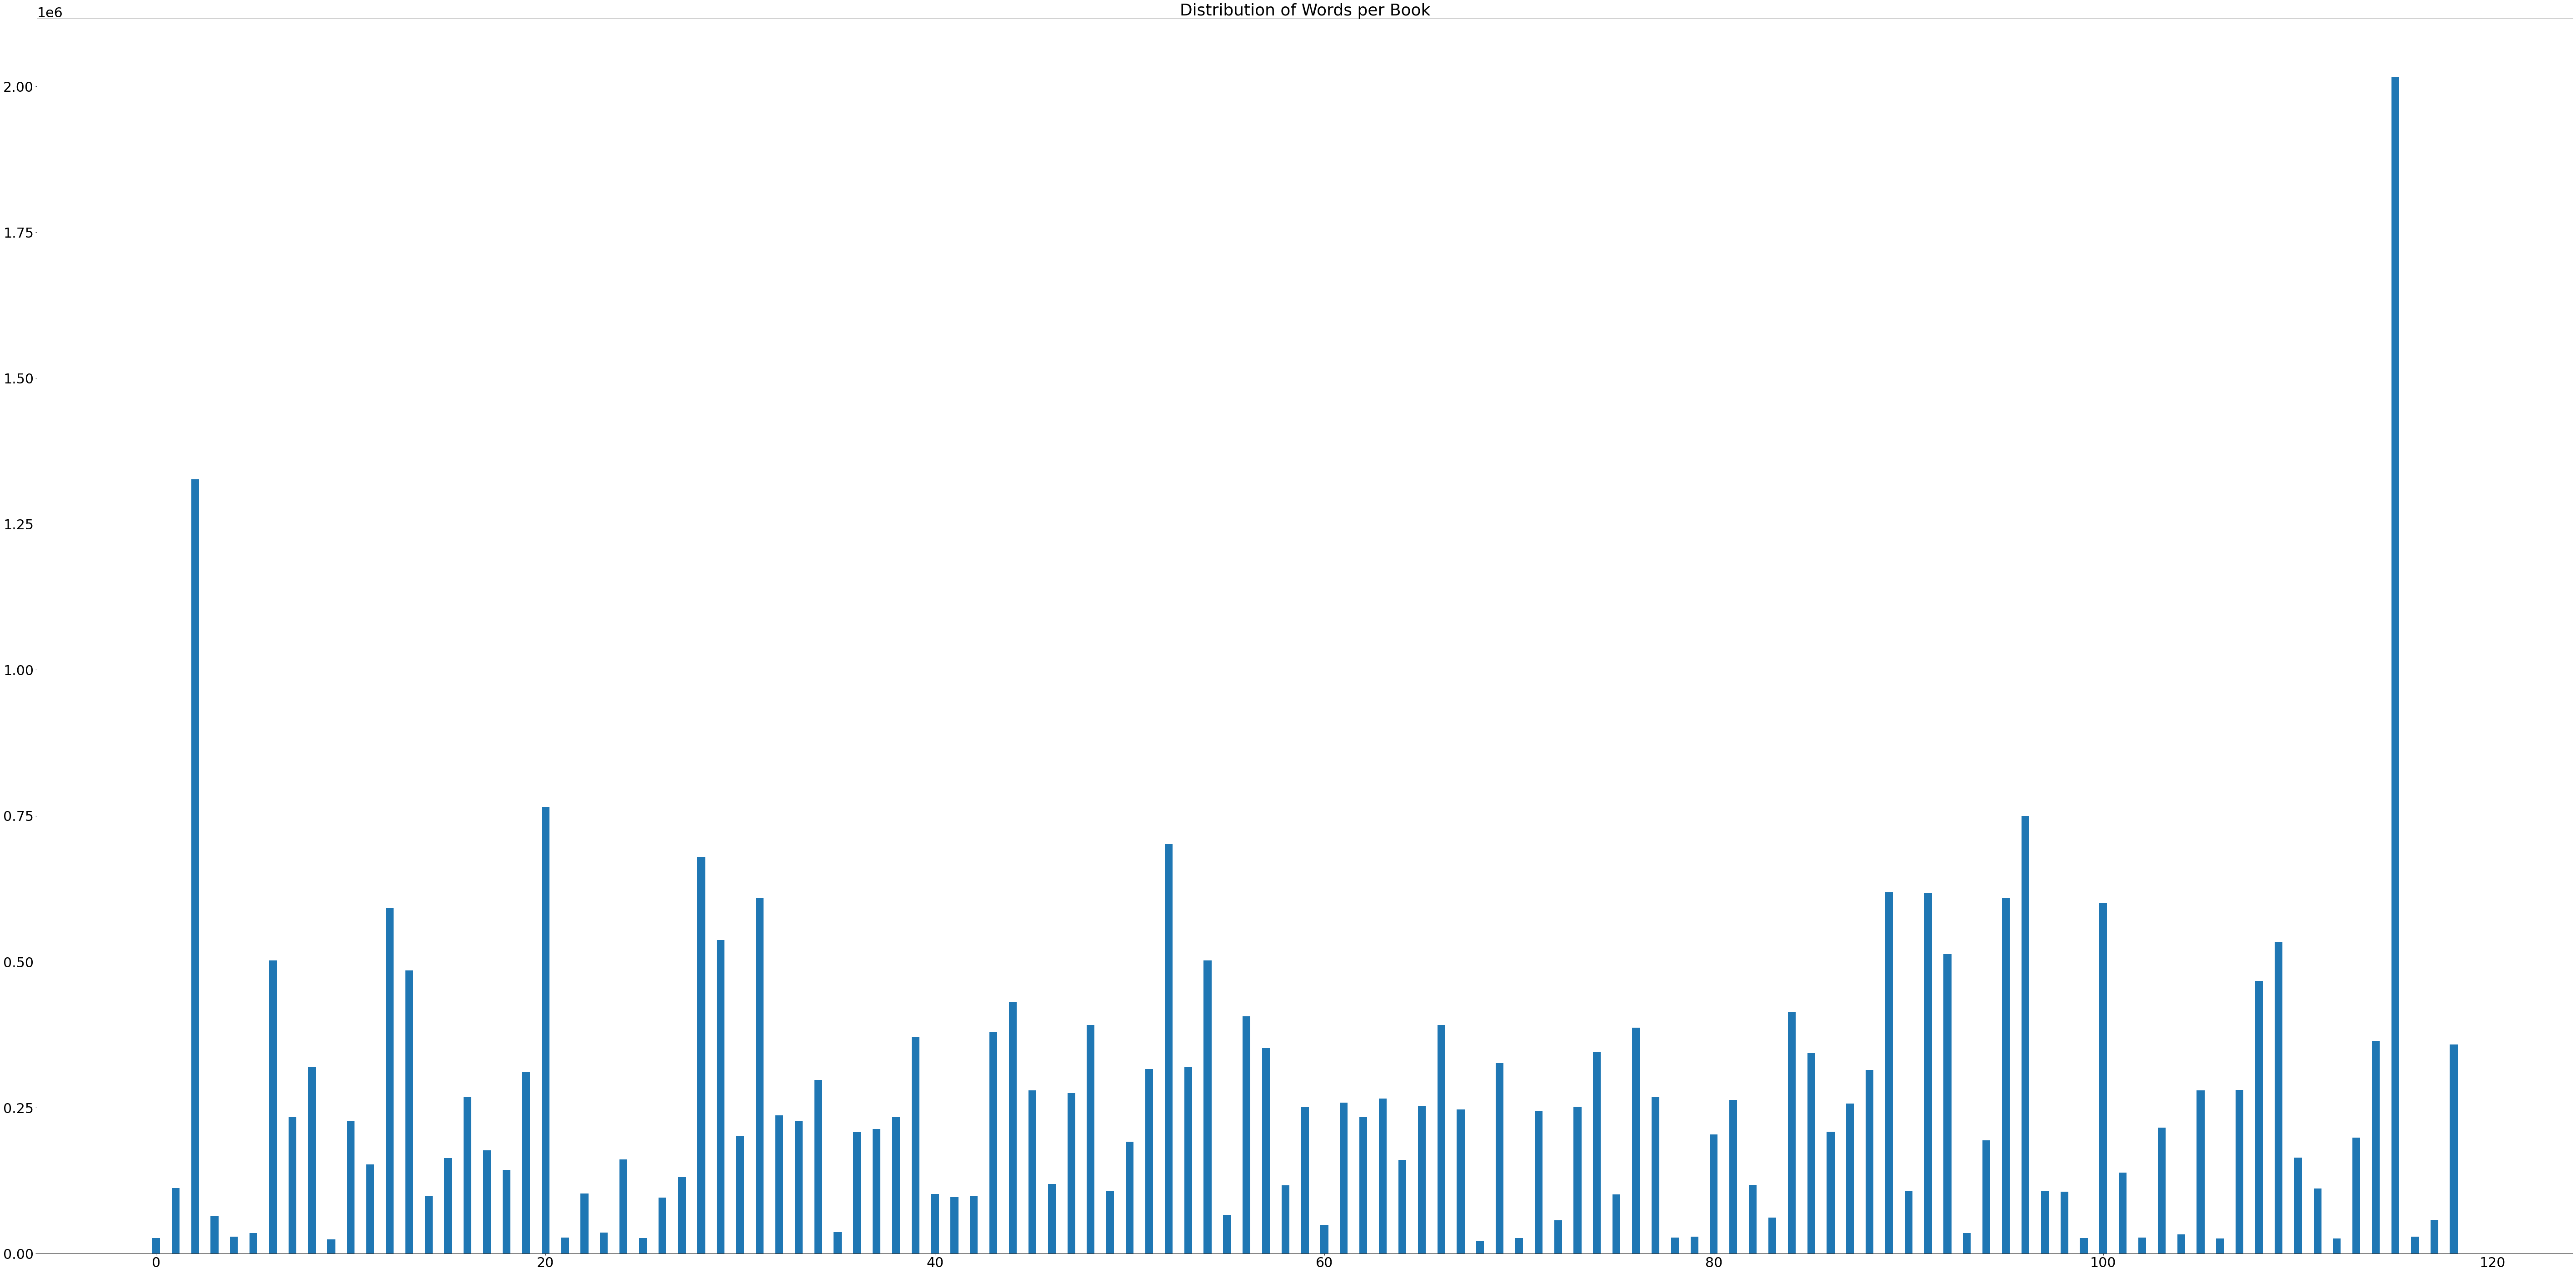

In [10]:
# Let's see the distribution of the number of words per book 
# There is a total of 120 books
# Initial insight- see that the largest instances, are compilations of books (misleading)

words_per_book=[]
for file in df_text[0]:
    words_per_book.append(len(file))
x_bins = list(df_text.index) 
plt.rcParams["figure.figsize"] = (100,50)
plt.rcParams.update({'font.size': 30})
plt.bar(x_bins, words_per_book, width = 0.4)
plt.title("Distribution of Words per Book")
plt.show()

### Gain Insights into Authors

Let's get some more initial insights. Next, I want to look at all of our Authors. Let's see how many total writers there are amongst all 120 books. I am looking for Authors who wrote more than one book, trying to gain insight into what writers wrote multiple books and what they wrote about. From this, we can more closely examine what a prevelant Author's text is like, and perhaps find common topics or themes. 


In [76]:
from collections import Counter
from itertools import repeat, chain
import matplotlib.pyplot as plt

# Count the number of books of all the authors, and take a closer look at top authors

ini_list = Author
x_values=[]
y_values=[]
writernumbers = collections.defaultdict(int)
for name in Author:
    writernumbers[name] += 1
writers = sorted(writernumbers.items(), key=lambda k_v: k_v[1], reverse=True)
print("These are all of the Authors and their Book Counts")
print("We have ",counter_books, "books, but fewer writers")

for writer, count in writers:
    if(count>1):
        x_values.append(writer)
        y_values.append(count)
    print(writer, ":", count)


These are all of the Authors and their Book Counts
We have  120 books, but fewer writers
Beatrix Potter : 12
Thornton W. Burgess : 10
Various : 8
Victor Appleton : 7
William Holmes McGuffey : 5
 : 3
Howard R. Garis : 3
Martha Finley : 3
Hans Christian Andersen : 3
Arthur Scott Bailey : 2
Charles Perrault : 2
Ernest Thompson Seton : 2
Anonymous : 2
Popular Mechanics : 1
Heinrich Hoffman : 1
Logan Marshall : 1
Edith Lavell : 1
Jacob Grimm and Wilhelm Grimm : 1
J. S. Zerbe : 1
Percy J. Billinghurst : 1
Francis C. Woodworth : 1
W. R. S. Ralston : 1
A.F. Mockler-Ferryman : 1
Clement C. Moore : 1
Arthur Owens Cooke : 1
Elsie Spicer Eells : 1
Dinah Maria Mulock (AKA Miss Mulock) : 1
Prince Sarath Ghosh : 1
Edwin A. Abbott : 1
Clara Dillingham Pierson : 1
Edward Lear : 1
Mrs. Alfred Gatty : 1
James Stephens : 1
Norman Hinsdale Pitman : 1
Charles Kingsley : 1
Arthur Shearly Cripps : 1
(Illustrated by Blanche Fisher Wright) : 1
Jennie Hall : 1
Wayne Whipple : 1
Maud Isabel Ebbutt : 1
E. Louise S

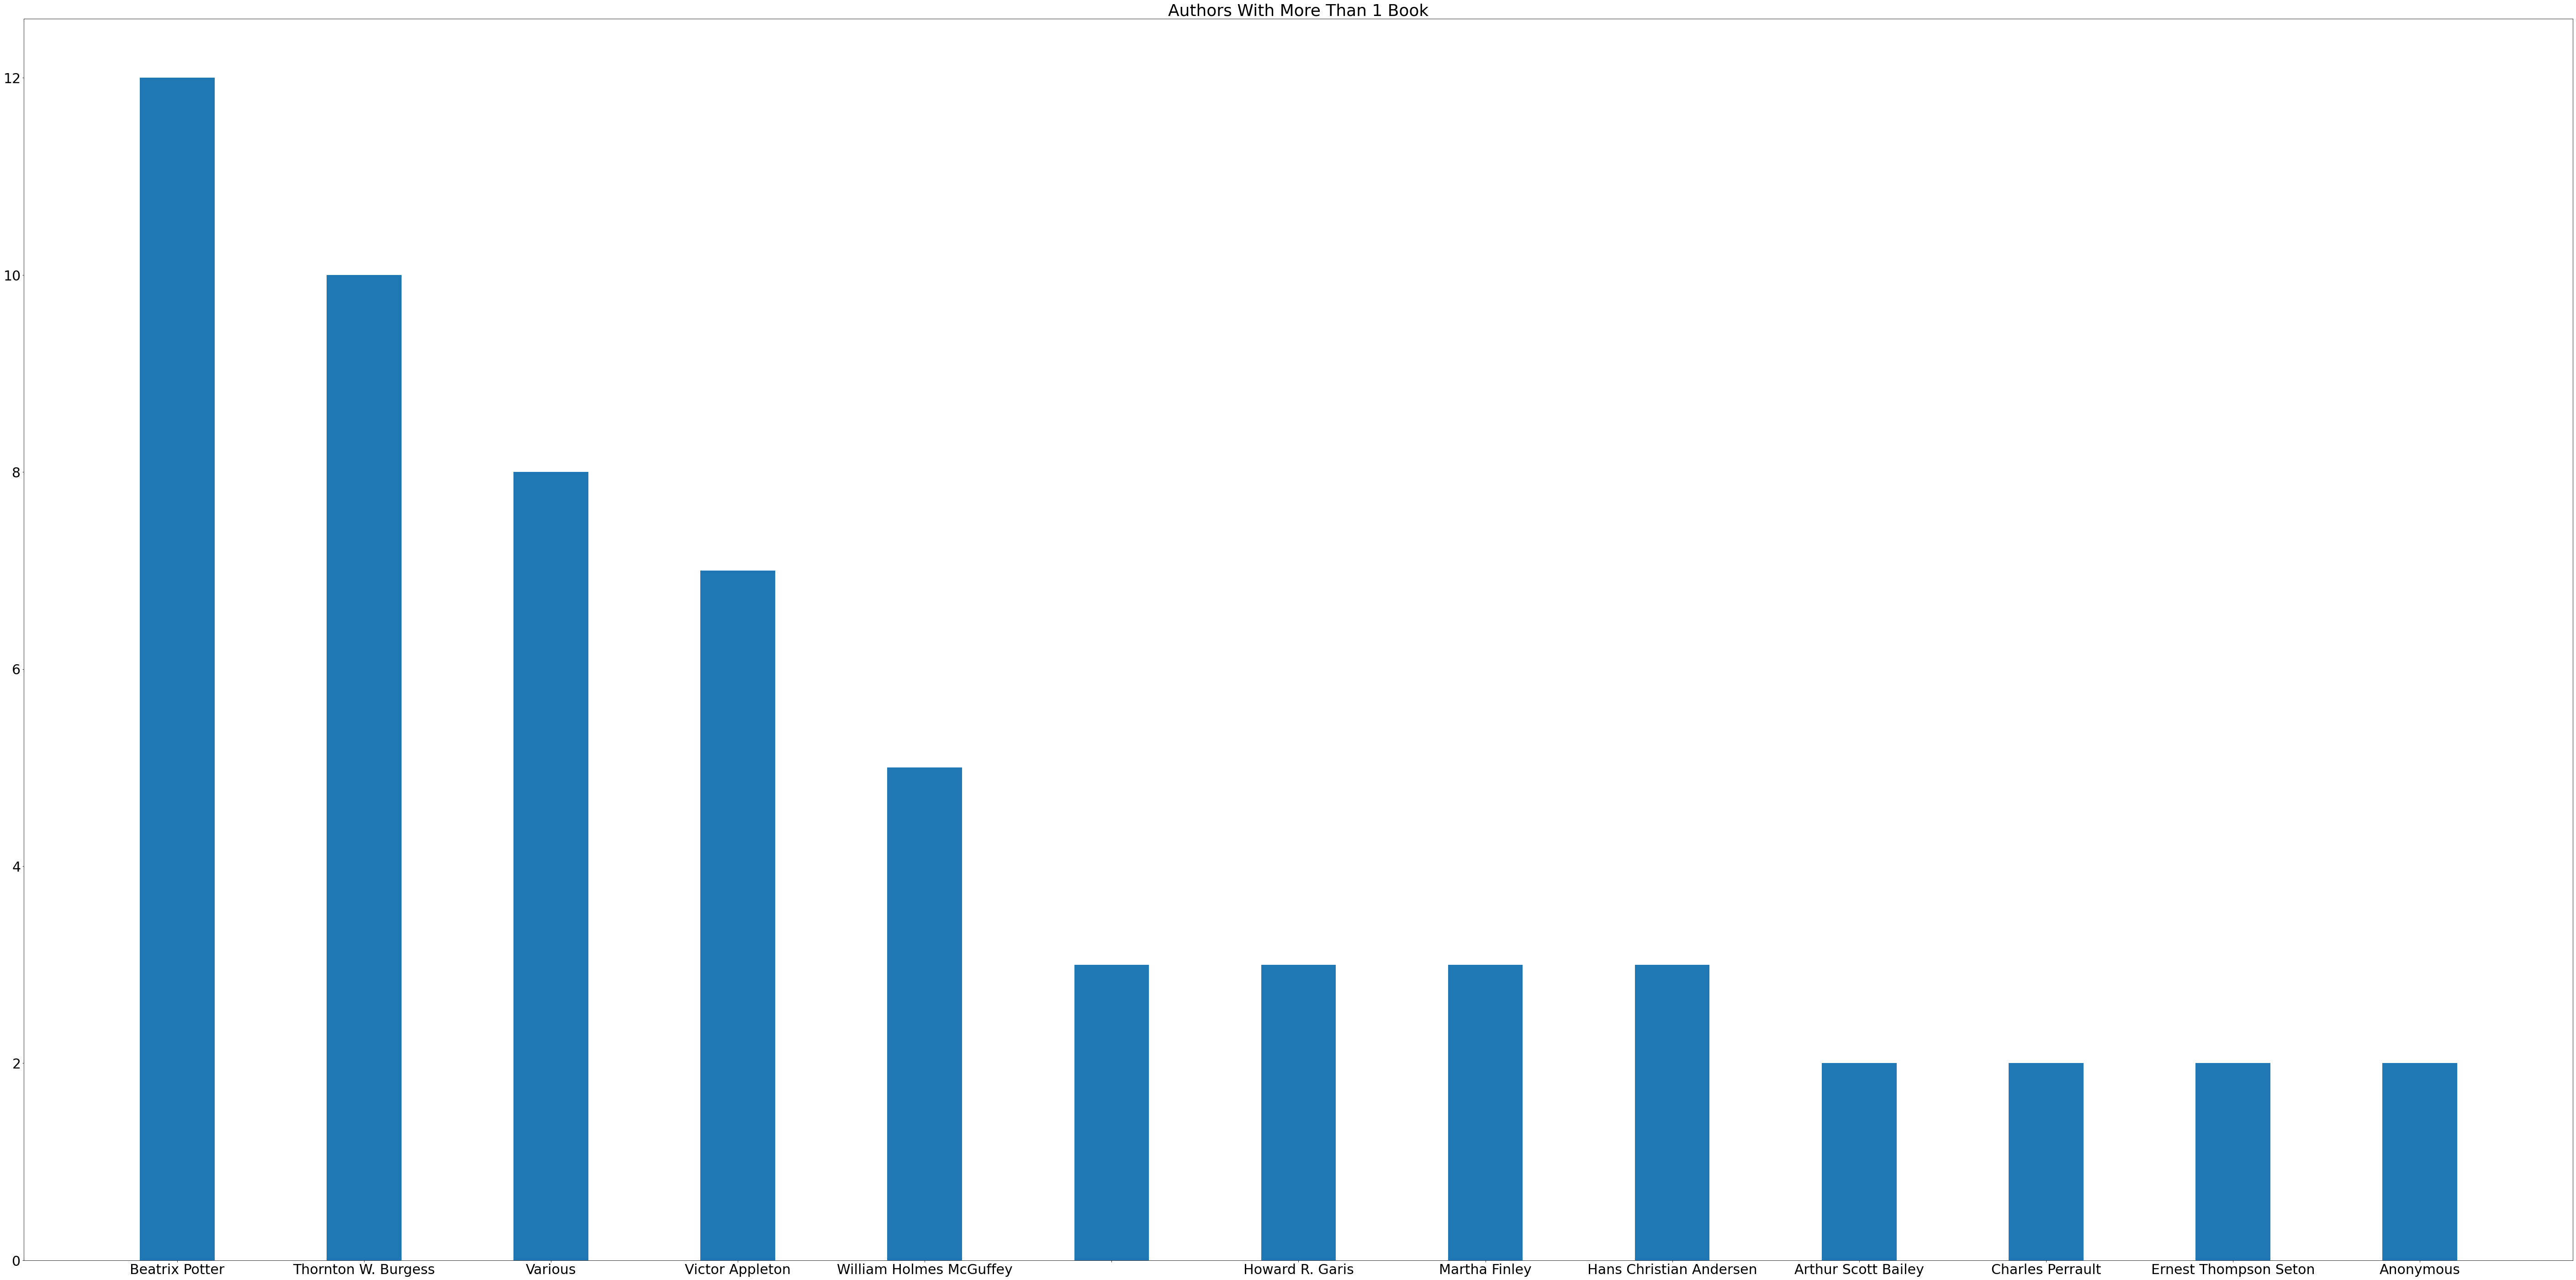

In [77]:
# Display graph of all the authors

plt.rcParams["figure.figsize"] = (100,50)
plt.rcParams.update({'font.size': 30})
plt.bar(x_values, y_values, width = 0.4)
plt.title("Authors With More Than 1 Book")
plt.show()

In [23]:
# How many total writers there are

x_values=[]
for writer, count in writers:
        x_values.append(writer)
print("We have",counter_books, "books and",len(x_values),"writers")

We have 120 books and 70 writers


### Examine Top 2 Authors More Closely

Now that we understand the authors more, lets take a closer look at just the 
top 2 authors (those who wrote the most books).

In [33]:
# This is examining the first author only:

First_Author=x_values[0]
print(First_Author)

# Create a different df with only the book info of this Author
rslt_df = df_text[df_text['Author'] == First_Author] 
rslt_df

Beatrix Potter


0  \
0    ﻿The Project Gutenberg EBook of The Tale Of Be...   
4    ﻿Project Gutenberg's The Tale of Mrs. Tiggy-Wi...   
9    ﻿The Project Gutenberg EBook of The Tale of To...   
11   ﻿\nProject Gutenberg's A Collection of Beatrix...   
21   ﻿The Project Gutenberg eBook, The Tale of John...   
35   ﻿The Project Gutenberg EBook of The Tailor of ...   
78   ﻿The Project Gutenberg EBook of The Tale of Sq...   
93   ﻿The Project Gutenberg eBook, The Tale of Samu...   
99   ﻿Project Gutenberg's The Tale of the Flopsy Bu...   
102  ﻿The Project Gutenberg eBook, The Tale of Jemi...   
112  ﻿The Project Gutenberg EBook of The Tale of Pe...   
116  ﻿Project Gutenberg's The Tale of Mrs. Tittlemo...   

                                      Title          Author  \
0                The Tale Of Benjamin Bunny  Beatrix Potter   
4             The Tale of Mrs. Tiggy-Winkle  Beatrix Potter   
9                    The Tale of Tom Kitten  Beatrix Potter   
11   A Collection of Beatrix Potter Stories  Beatrix Potter   
21            The Tale of Johnny Town-Mouse  Beatrix Potter   
35                 The Tailor of Gloucester  Beatrix Potter   
78              The Tale of Squirrel Nutkin  Beatrix Potter   
93              The Tale of Samuel Whiskers  Beatrix Potter   
99           The Tale of the Flopsy Bunnies  Beatrix Potter   
102          The Tale of Jemima Puddle-Duck  Beatrix Potter   
112                The Tale of Peter Rabbit  Beatrix Potter   
116            The Tale of Mrs. Tittlemouse  Beatrix Potter   

                         Release Date  
0    December 21, 2004 [EBook #14407]  
4    February 22, 2005 [EBook #15137]  
9     January 29, 2005 [EBook #14837]  
11                         July, 1996  
21      March 8, 2005  [eBook #15284]  
35    February 2, 2005 [EBook #14868]  
78    February 2, 2005 [EBook #14872]  
93      April 6, 2005  [eBook #15575]  
99   November 30, 2004 [EBook #14220]  
102  January 27, 2005  [eBook #14814]  
112   January 30, 2005 [EBook #14838]  
116  November 18, 2005 [EBook #17089]

### Stopwords

Before we begin any more EDA, lets add our stop words. This will help in the next step as we examine the text of the authors books. 

In [18]:
# Import stopwords and display them
# Let's see what the basics are, add to them after

from nltk.corpus import stopwords
stopwords=stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [20]:
# Created new set of stop words (ongoing process)

new_stop_words_list=['a', 'i', 'mr', 'ms', 'mrs', 'one', 'two', 'said', '0', '1', '2','3', '4', '5', '6', '7', '8' '9','_a_',
                    '_b_', '_c_','project', 'gutenbergtm', 'gutenberg', 'illustration', 'archive', 'literary', 'copy',
                    'electronic', 'work', 'works', 'foundation','agreement', 'terms', 'may', 'license', 'states', 'copyright',
                    'donations', 'see', 'know', 'end', 'ebook', 'oh','would', 'wouldnt', 'could', 'couldnt', 'should', 
                    'shouldnt', 'went', 'came', 'come', 'go',
#                   'going', 'saw', 'shall', 'well', 'soon', 'never', 'im', 'upon', 'get', 'made', 'series', 'see', 'away', 
#                   'with','without', 'time', 'little', 'quite', 'many', 'also', 'use', 'must', 'though', 'great', 'didnt', 
#                   'like', 'big','till', 'rather', 'old', 'yes', 'us', 'tom', 'get', 'got', 'began', 'full', 'made', 'know', 
#                   'never', 'told',
                    'access', 'set', 'public', 'agree', 'associated', 'domain', 'fee', 'laws', 'forth', 'ebooks', 'copies', 
                    'section', 'online', 'paragraph', 'trademark']

stopwords = stopwords+new_stop_words_list

### Author 1

From above, we found that the author who wrote the most books was Beatrix Potter. Let's look at all of the 12 books she wrote more closely, before diving into all of the dataset. We will look at the most frequent words she used in all of her books separately. Then, add in some visualizations for EDA purposes. 

In [82]:
# Create a function that will loop through each book from author 1 books only
# Finding the most frequent words in each of their books 

stopwords = stopwords
counter=0
Number_of_words_Author_1=[]
Book_name_Author_1=[]

'''
This function will look at all of the books written by Author 1, chosen from above, 
and display the top 10 most frequent words used in each book
'''

for file in rslt_df[0]:
            print("Book Release Date is:",rslt_df["Release Date"].iloc[counter])
            Book_name_Author_1.append(rslt_df["Title"].iloc[counter])
            Number_of_words_Author_1.append(len(file))
            wordcount = collections.defaultdict(int)
            pattern = r"\W"
            for word in file.lower().split():
                word = re.sub(pattern, '', word)
                if word not in stopwords:
                    wordcount[word] += 1
            #Author 1
            print_top=10
            mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:print_top]
            mc = dict(mc)
            names = list(mc.keys())
            values = list(mc.values())
            print(mc)
            print()
            counter=counter+1



Book Release Date is: December 17, 2004  [eBook #14375]
{'grandfather': 340, 'frog': 314, 'little': 141, 'old': 106, 'great': 101, 'pool': 88, 'smiling': 87, 'long': 76, 'longlegs': 70, 'farmer': 68}

Book Release Date is: April 1, 2005 [EBook #15521]
{'peter': 204, 'old': 130, 'prickly': 111, 'porky': 107, 'little': 90, 'unc': 85, 'billy': 84, 'fox': 83, 'hill': 76, 'reddy': 73}

Book Release Date is: February, 2004  [EBook #5110]
{'jerry': 226, 'grandfather': 150, 'frog': 149, 'little': 114, 'muskrat': 111, 'smiling': 109, 'pool': 109, 'laughing': 107, 'brook': 95, 'spotty': 80}

Book Release Date is: July, 1999
{'fox': 348, 'reddy': 255, 'granny': 198, 'old': 129, 'farmer': 98, 'browns': 96, 'boy': 90, 'little': 84, 'peter': 84, 'bowser': 76}

Book Release Date is: December, 2000  [Etext #2441]
{'old': 546, 'mother': 465, 'peter': 448, 'nature': 444, 'little': 423, 'like': 278, 'family': 266, 'long': 229, 'much': 226, 'great': 222}

Book Release Date is: June 15, 2004 [EBook #12630]

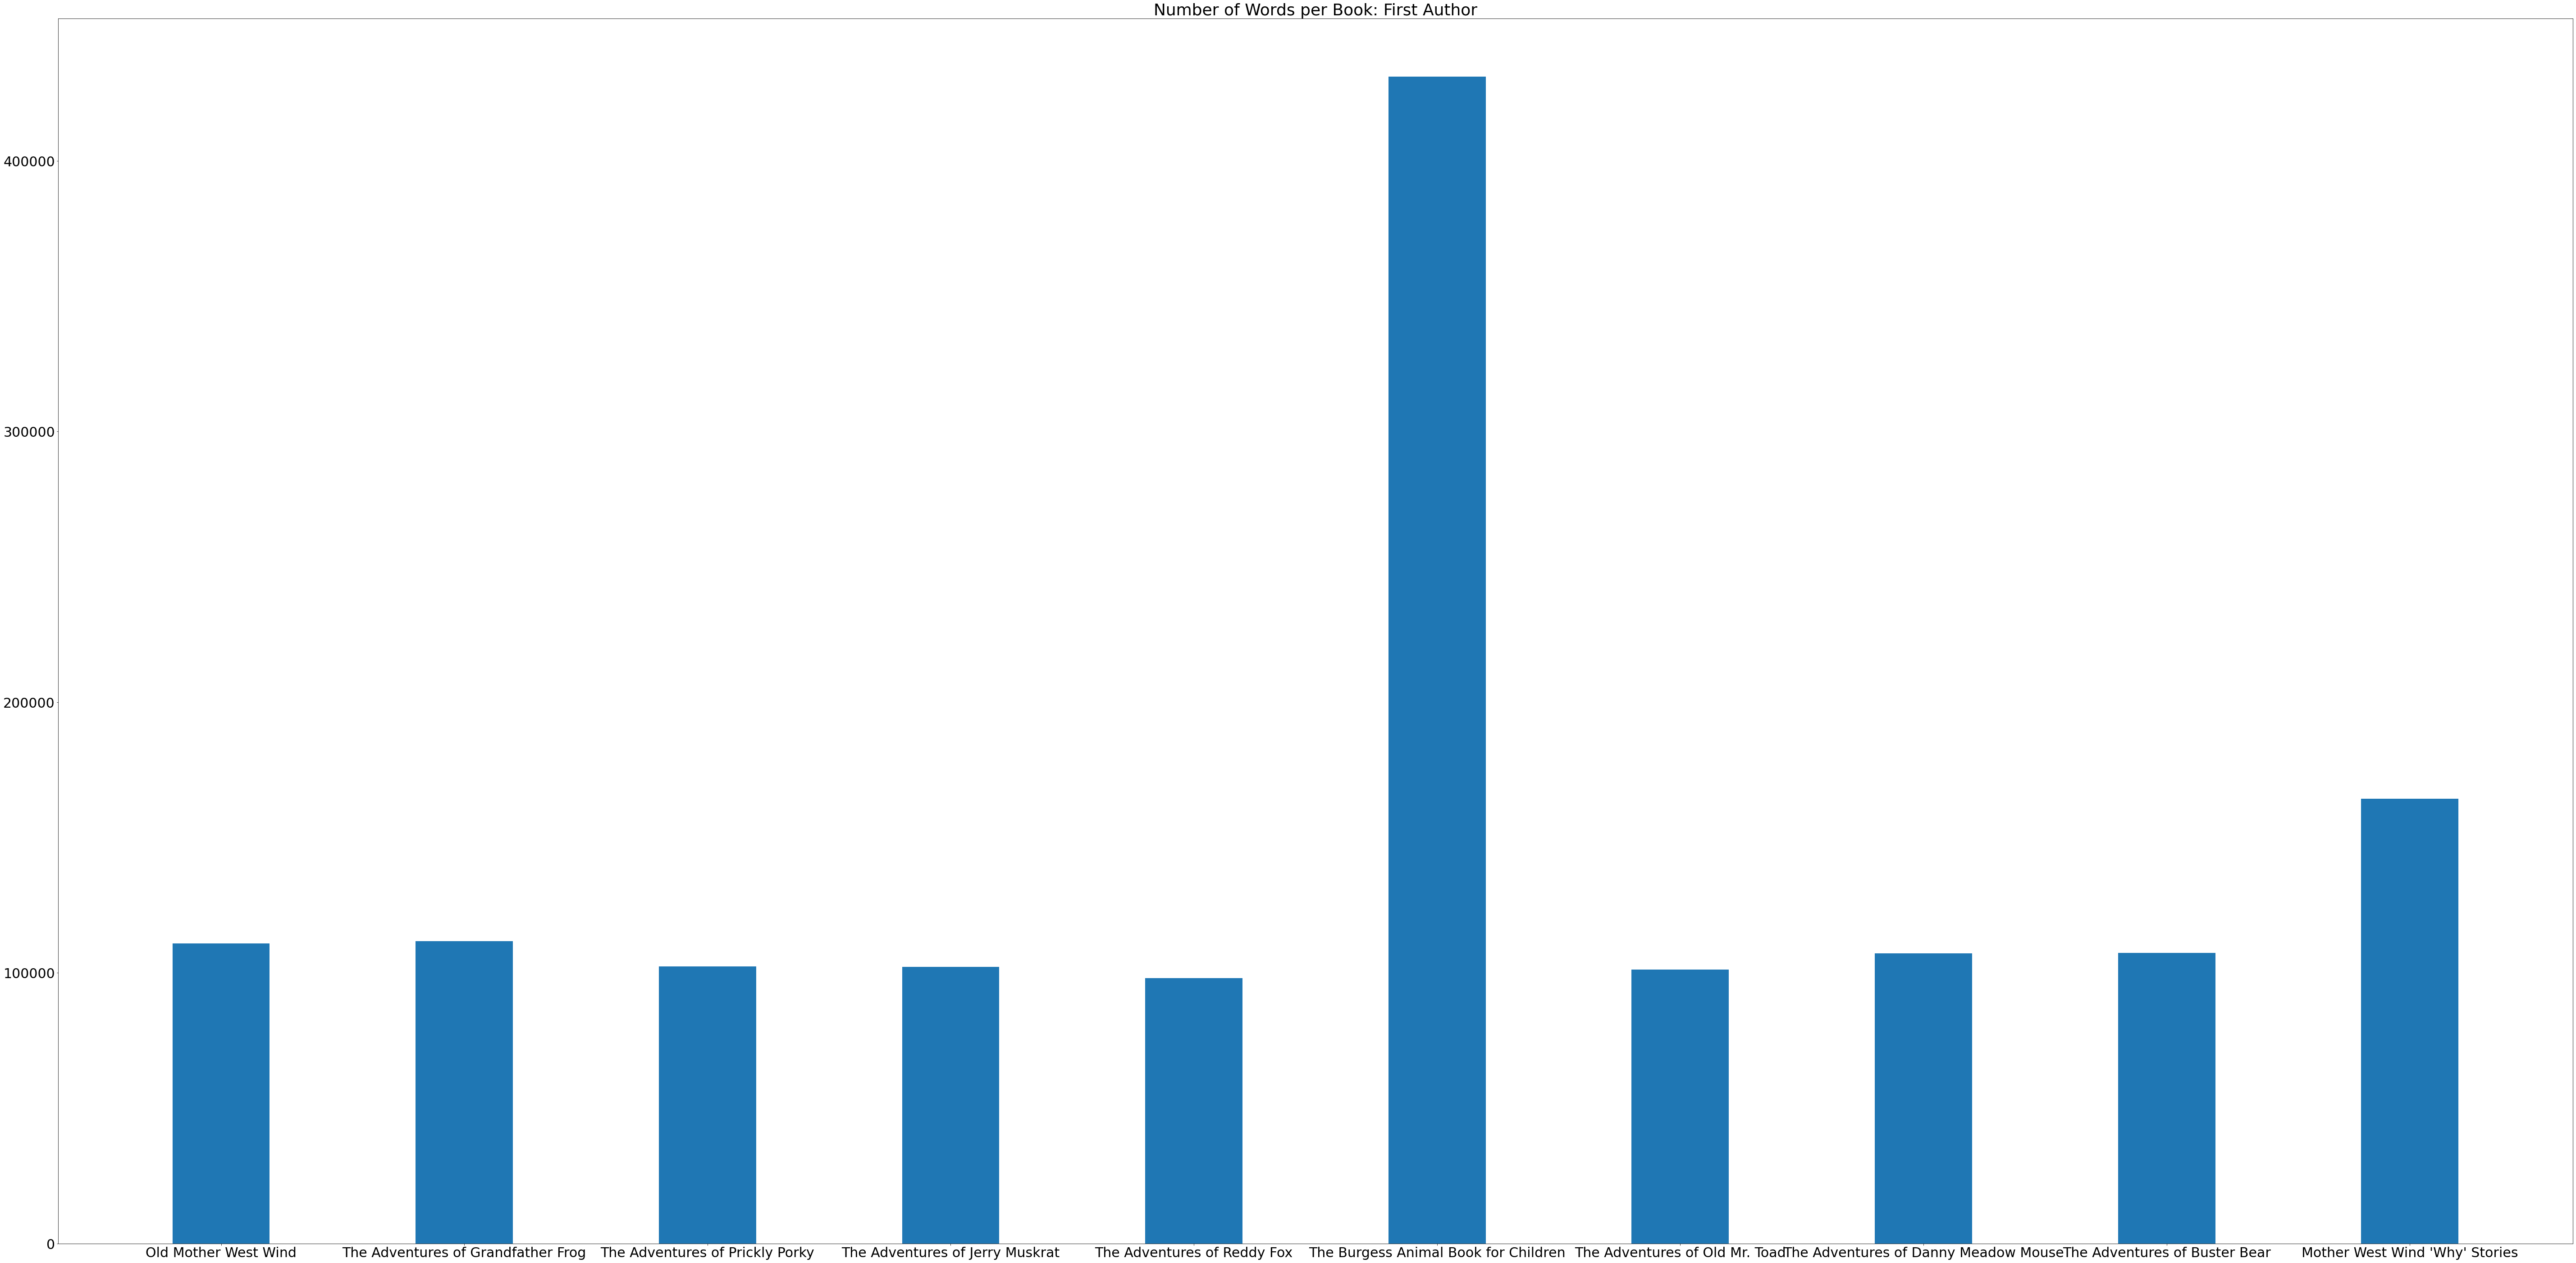

In [83]:
# Display graph of words

plt.rcParams["figure.figsize"] = (100,50)
plt.rcParams.update({'font.size': 30})
Book_name_Author_1=Book_name_Author_1[-1:]+Book_name_Author_1[:-1] 
Number_of_words_Author_1=Number_of_words_Author_1[-1:]+Number_of_words_Author_1[:-1] 
plt.bar(Book_name_Author_1, Number_of_words_Author_1, width = 0.4)
plt.title("Number of Words per Book: First Author")
plt.show()

### Top 5 Words of Author 1

Now, let's display the overall top 5 words Beatrix used in her books. This will give us a generally good idea about what her books are about.  We can use this information to try to account for any biases, as well as look for topics and themes.

{'old': 1818, 'little': 1715, 'peter': 1498, 'fox': 865, 'grandfather': 797, 'frog': 744, 'reddy': 727, 'mother': 689, 'way': 674, 'green': 642}



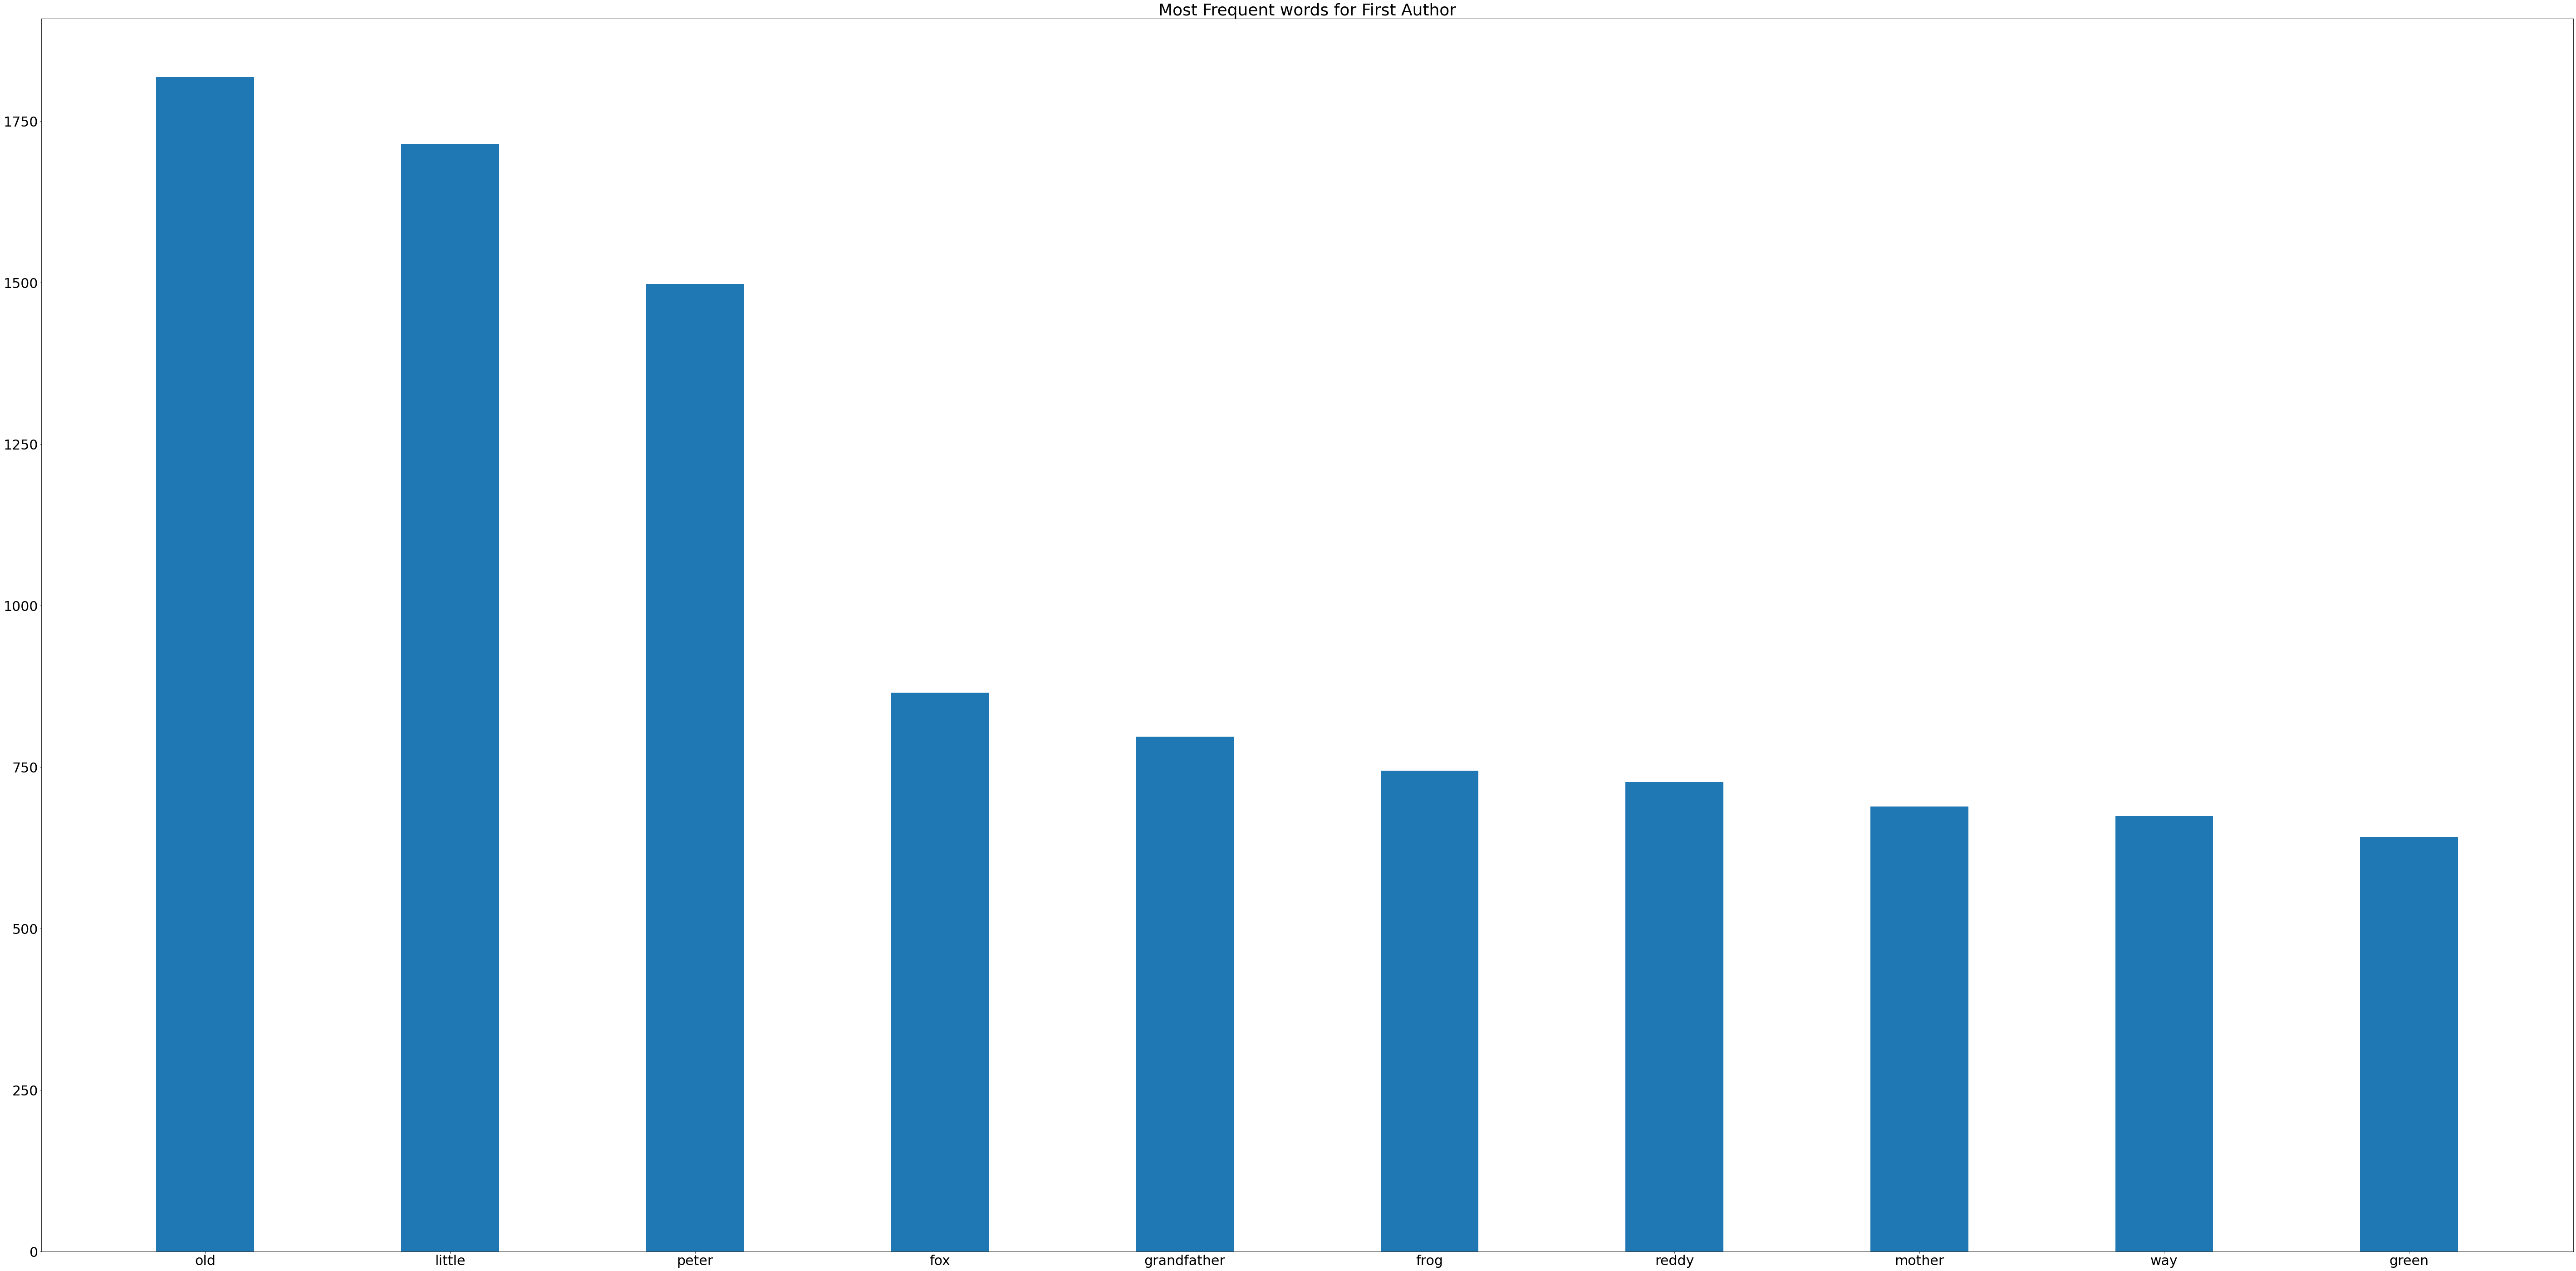

In [79]:
stopwords = stopwords
counter=0
file=[]

for x in rslt_df[0]:
    x=x.lower().split()
    file.append(x)
wordcount = collections.defaultdict(int)
pattern = r"\W"
for book in file:
    for word in book:
        word = re.sub(pattern, '', word)
        if word not in stopwords:
            wordcount[word] += 1            
print_top=10
mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:print_top]
mc = dict(mc)
names = list(mc.keys())
values = list(mc.values())
print(mc)
print() 

plt.rcParams["figure.figsize"] = (100,50)
plt.rcParams.update({'font.size': 30})
plt.bar(names, values, width = 0.4)
plt.title("Most Frequent words for First Author")
plt.show()


### Wordcloud of Author 1

Display a Wordcloud of all of the book titles from author 1, Beatrix Potter. This visualization is of *titles*  not all of her text. This is created for visualization purposes to see if we can easily spot theme and understand what her books are generally about.

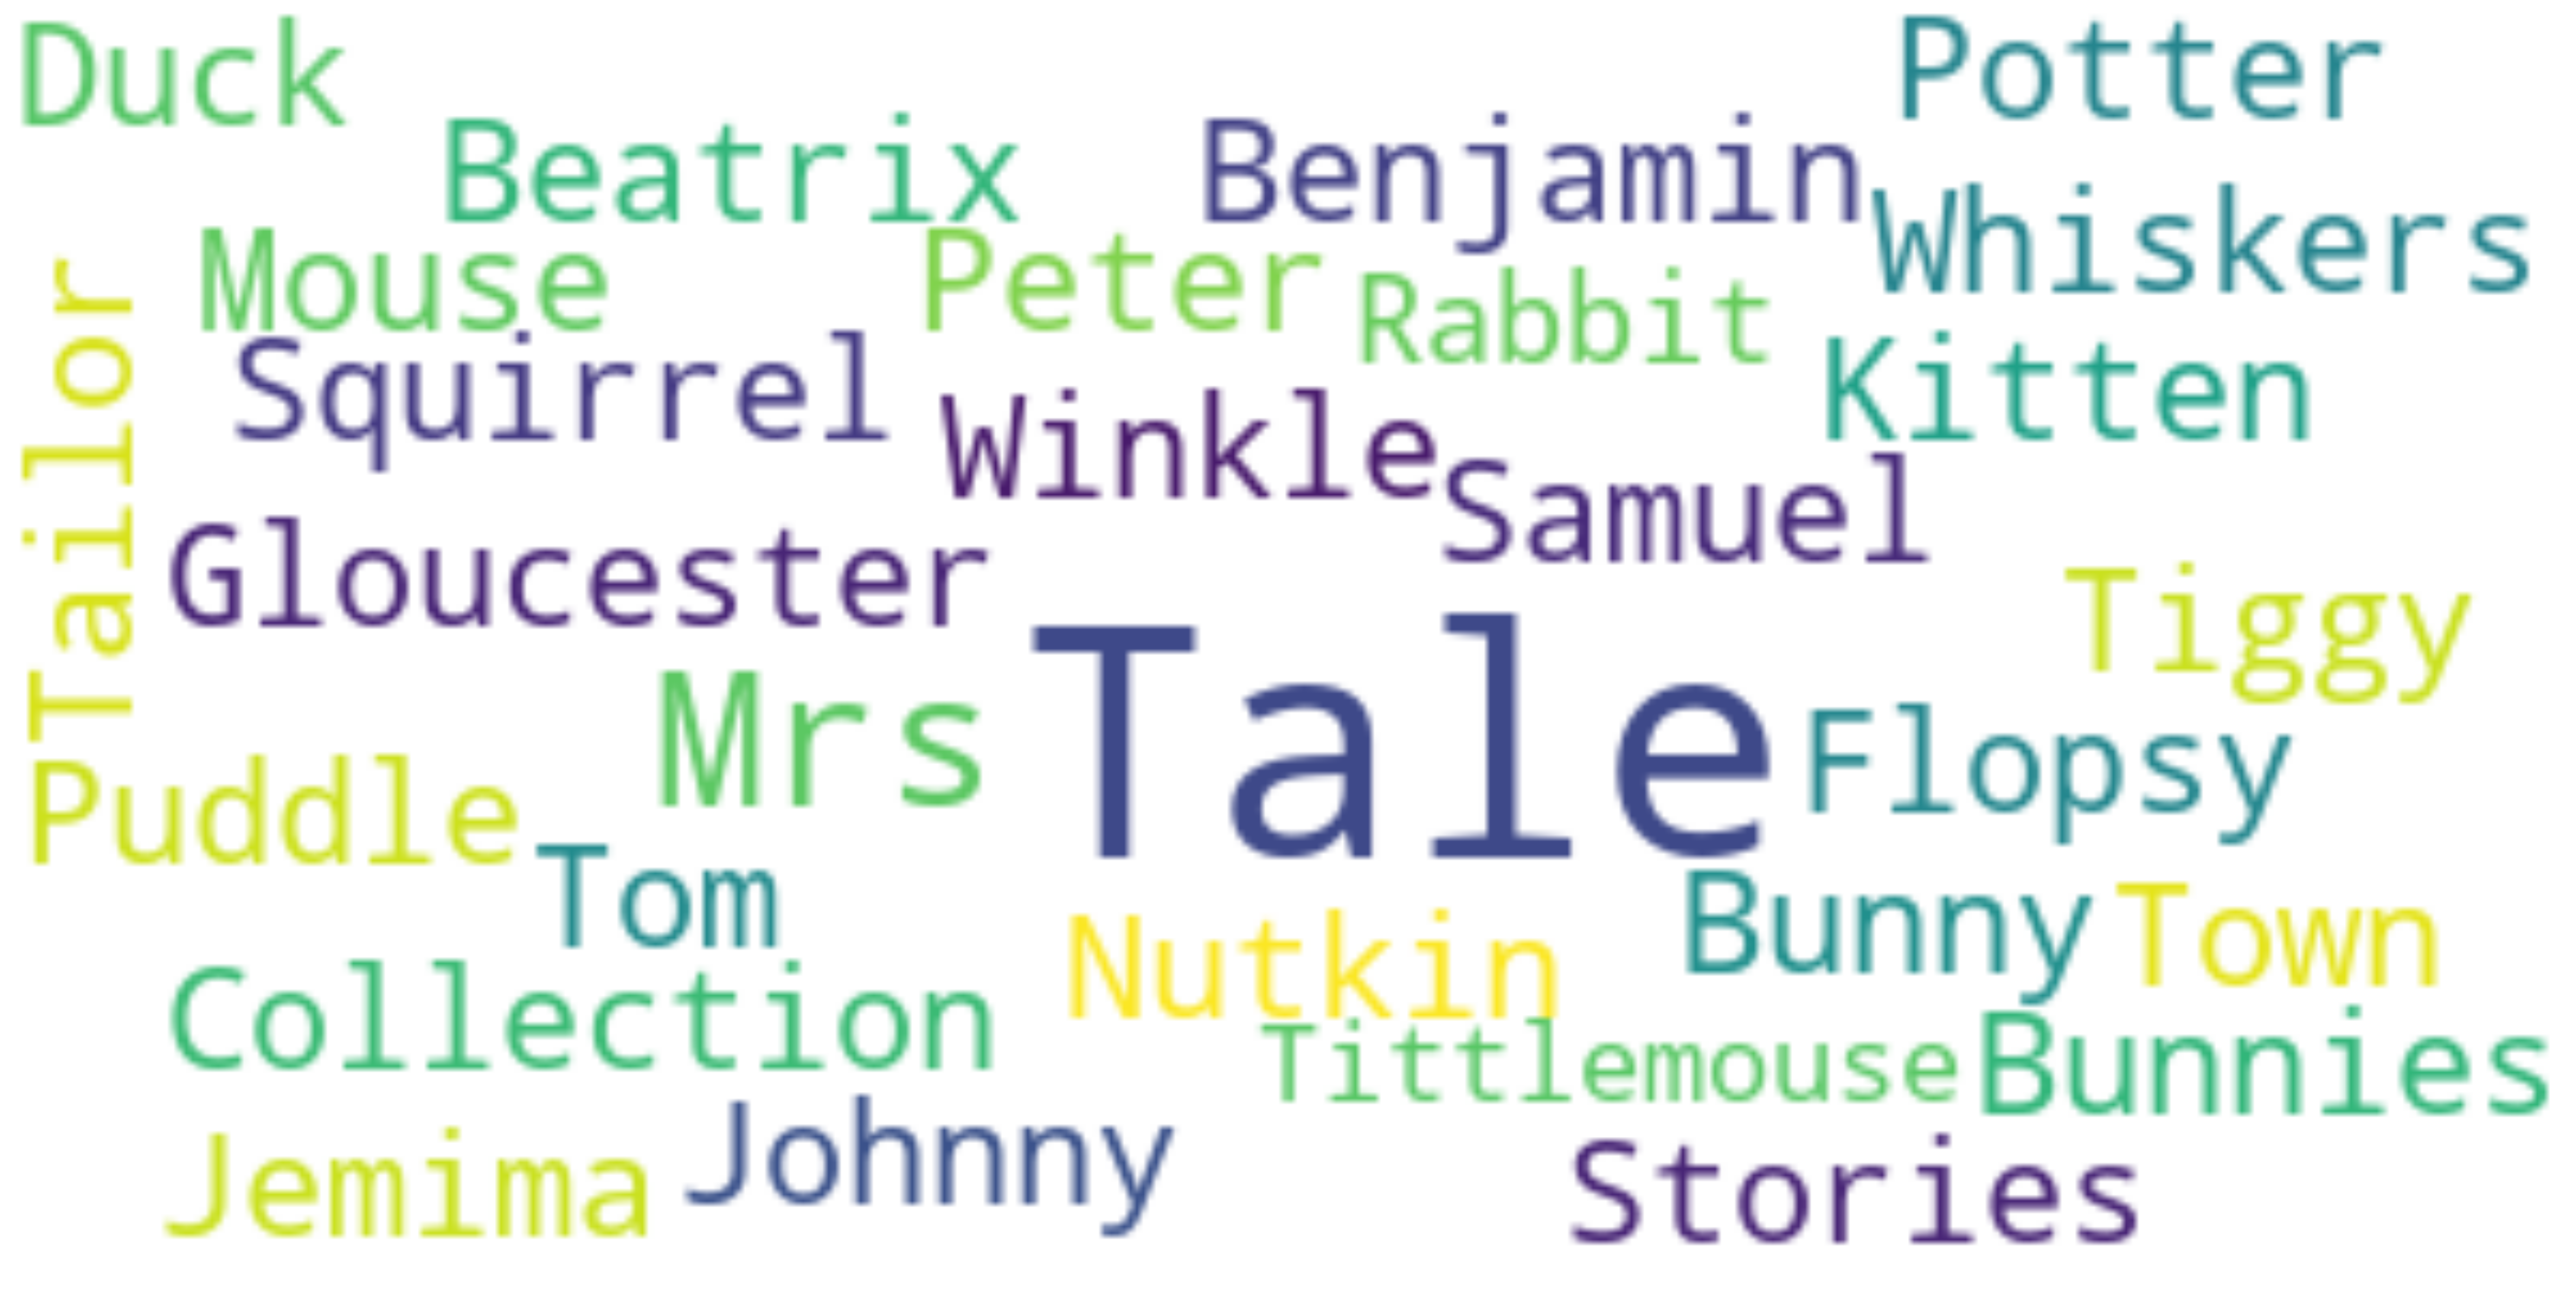

In [19]:
# Beatrix Potter Book Titles Wordcloud

text=" "
for file in rslt_df["Title"]:
    text += " "+file+" "
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Author 2

From above, we found that the author who wrote the next most amount of books was Thornton W. Burgess. Let's look at all of the 10 books he wrote more closely, before diving into all of the dataset. We will look at the most frequent words he used in all of his books separately. Then, add in some visualizations for EDA purposes. 

In [34]:
# Let's take a look at examining the second author now:

Second_Author=x_values[1]
print(Second_Author)
rslt_df = df_text[df_text['Author'] == Second_Author] 
rslt_df

Thornton W. Burgess


0  \
1    ﻿The Project Gutenberg eBook, The Adventures o...   
22   ﻿Project Gutenberg's The Adventures of Prickly...   
40   ﻿Project Gutenberg's The Adventures of Jerry M...   
42   ﻿Project Gutenberg's The Adventures of Reddy F...   
44   ﻿The Project Gutenberg EBook of The Burgess An...   
75   ﻿Project Gutenberg's The Adventures of Old Mr....   
90   ﻿The Project Gutenberg EBook of The Adventures...   
97   ﻿Project Gutenberg's The Adventures of Buster ...   
110  ﻿Project Gutenberg's Mother West Wind 'Why' St...   
111  ﻿The Project Gutenberg EBook of Old Mother Wes...   

                                    Title               Author  \
1      The Adventures of Grandfather Frog  Thornton W. Burgess   
22        The Adventures of Prickly Porky  Thornton W. Burgess   
40        The Adventures of Jerry Muskrat  Thornton W. Burgess   
42            The Adventures of Reddy Fox  Thornton W. Burgess   
44   The Burgess Animal Book for Children  Thornton W. Burgess   
75         The Adventures of Old Mr. Toad  Thornton W. Burgess   
90   The Adventures of Danny Meadow Mouse  Thornton W. Burgess   
97          The Adventures of Buster Bear  Thornton W. Burgess   
110        Mother West Wind 'Why' Stories  Thornton W. Burgess   
111                  Old Mother West Wind  Thornton W. Burgess   

                          Release Date  
1    December 17, 2004  [eBook #14375]  
22        April 1, 2005 [EBook #15521]  
40       February, 2004  [EBook #5110]  
42                          July, 1999  
44       December, 2000  [Etext #2441]  
75        June 15, 2004 [EBook #12630]  
90         May 19, 2008 [EBook #25529]  
97   September 30, 2007 [EBook #22816]  
110    February 7, 2005 [EBook #14958]  
111                        March, 2001

In [85]:
# Create a function that will loop through each book from author 2 only
# Finding the most frequent words in each of their books

stopwords = stopwords
counter=0
Number_of_words_Author_2=[]
Book_name_Author_2=[]

'''
This function will look at all of the books written by Author 2, chosen above, 
and display the top 10 most frequent words used in each book
'''

for file in rslt_df[0]:
            print("Book Release Date is:",rslt_df["Release Date"].iloc[counter])
            Book_name_Author_2.append(rslt_df["Title"].iloc[counter])
            Number_of_words_Author_2.append(len(file))
            wordcount = collections.defaultdict(int)
            pattern = r"\W"
            for word in file.lower().split():
                word = re.sub(pattern, '', word)
                if word not in stopwords:
                    wordcount[word] += 1
            #Author 2
            print_top=10
            mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:print_top]
            mc = dict(mc)
            names = list(mc.keys())
            values = list(mc.values())
            print(mc)
            print()
            counter=counter+1


Book Release Date is: December 17, 2004  [eBook #14375]
{'grandfather': 340, 'frog': 314, 'little': 141, 'old': 106, 'great': 101, 'pool': 88, 'smiling': 87, 'long': 76, 'longlegs': 70, 'farmer': 68}

Book Release Date is: April 1, 2005 [EBook #15521]
{'peter': 204, 'old': 130, 'prickly': 111, 'porky': 107, 'little': 90, 'unc': 85, 'billy': 84, 'fox': 83, 'hill': 76, 'reddy': 73}

Book Release Date is: February, 2004  [EBook #5110]
{'jerry': 226, 'grandfather': 150, 'frog': 149, 'little': 114, 'muskrat': 111, 'smiling': 109, 'pool': 109, 'laughing': 107, 'brook': 95, 'spotty': 80}

Book Release Date is: July, 1999
{'fox': 348, 'reddy': 255, 'granny': 198, 'old': 129, 'farmer': 98, 'browns': 96, 'boy': 90, 'little': 84, 'peter': 84, 'bowser': 76}

Book Release Date is: December, 2000  [Etext #2441]
{'old': 546, 'mother': 465, 'peter': 448, 'nature': 444, 'little': 423, 'like': 278, 'family': 266, 'long': 229, 'much': 226, 'great': 222}

Book Release Date is: June 15, 2004 [EBook #12630]

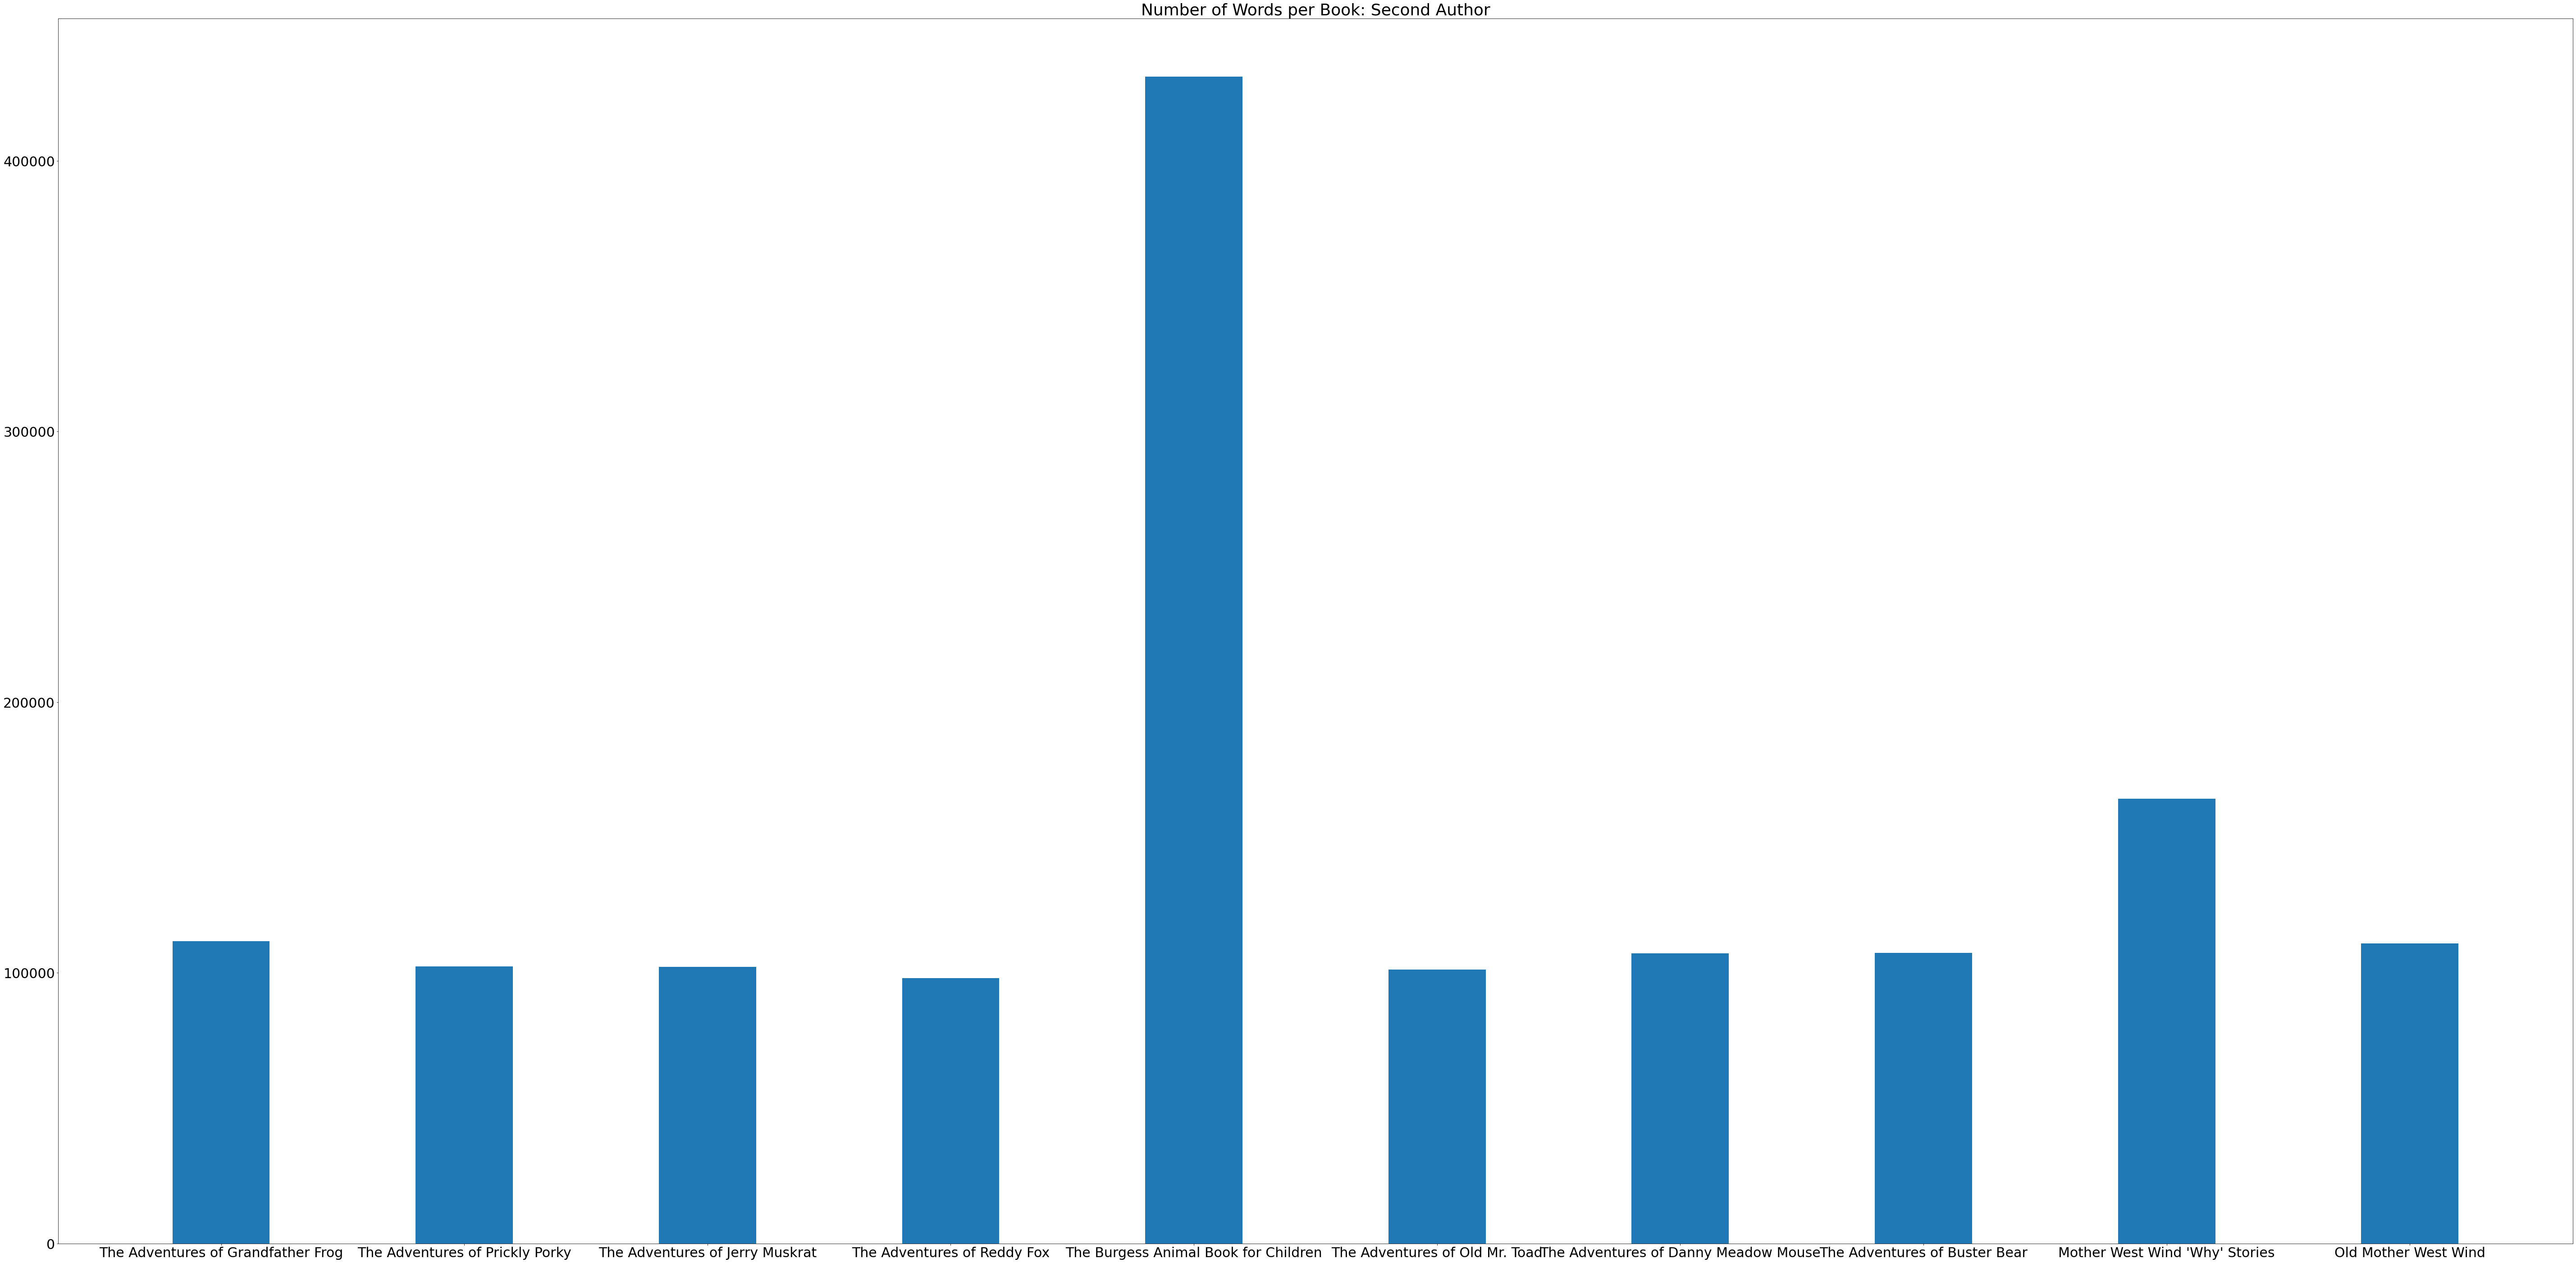

In [86]:
# Display graph of words

plt.rcParams["figure.figsize"] = (100,50)
plt.rcParams.update({'font.size': 30})
plt.bar(Book_name_Author_2, Number_of_words_Author_2, width = 0.4)
plt.title("Number of Words per Book: Second Author")
plt.show()

### Top 5 Words of Author 2

Now, let's display the overall top 5 words Burgess used in his books. This will give us a generally good idea about what his books are about.  We can use this information to try to account for any biases, as well as look for topics and themes.

{'old': 1818, 'little': 1715, 'peter': 1498, 'fox': 865, 'grandfather': 797, 'frog': 744, 'reddy': 727, 'mother': 689, 'way': 674, 'green': 642}



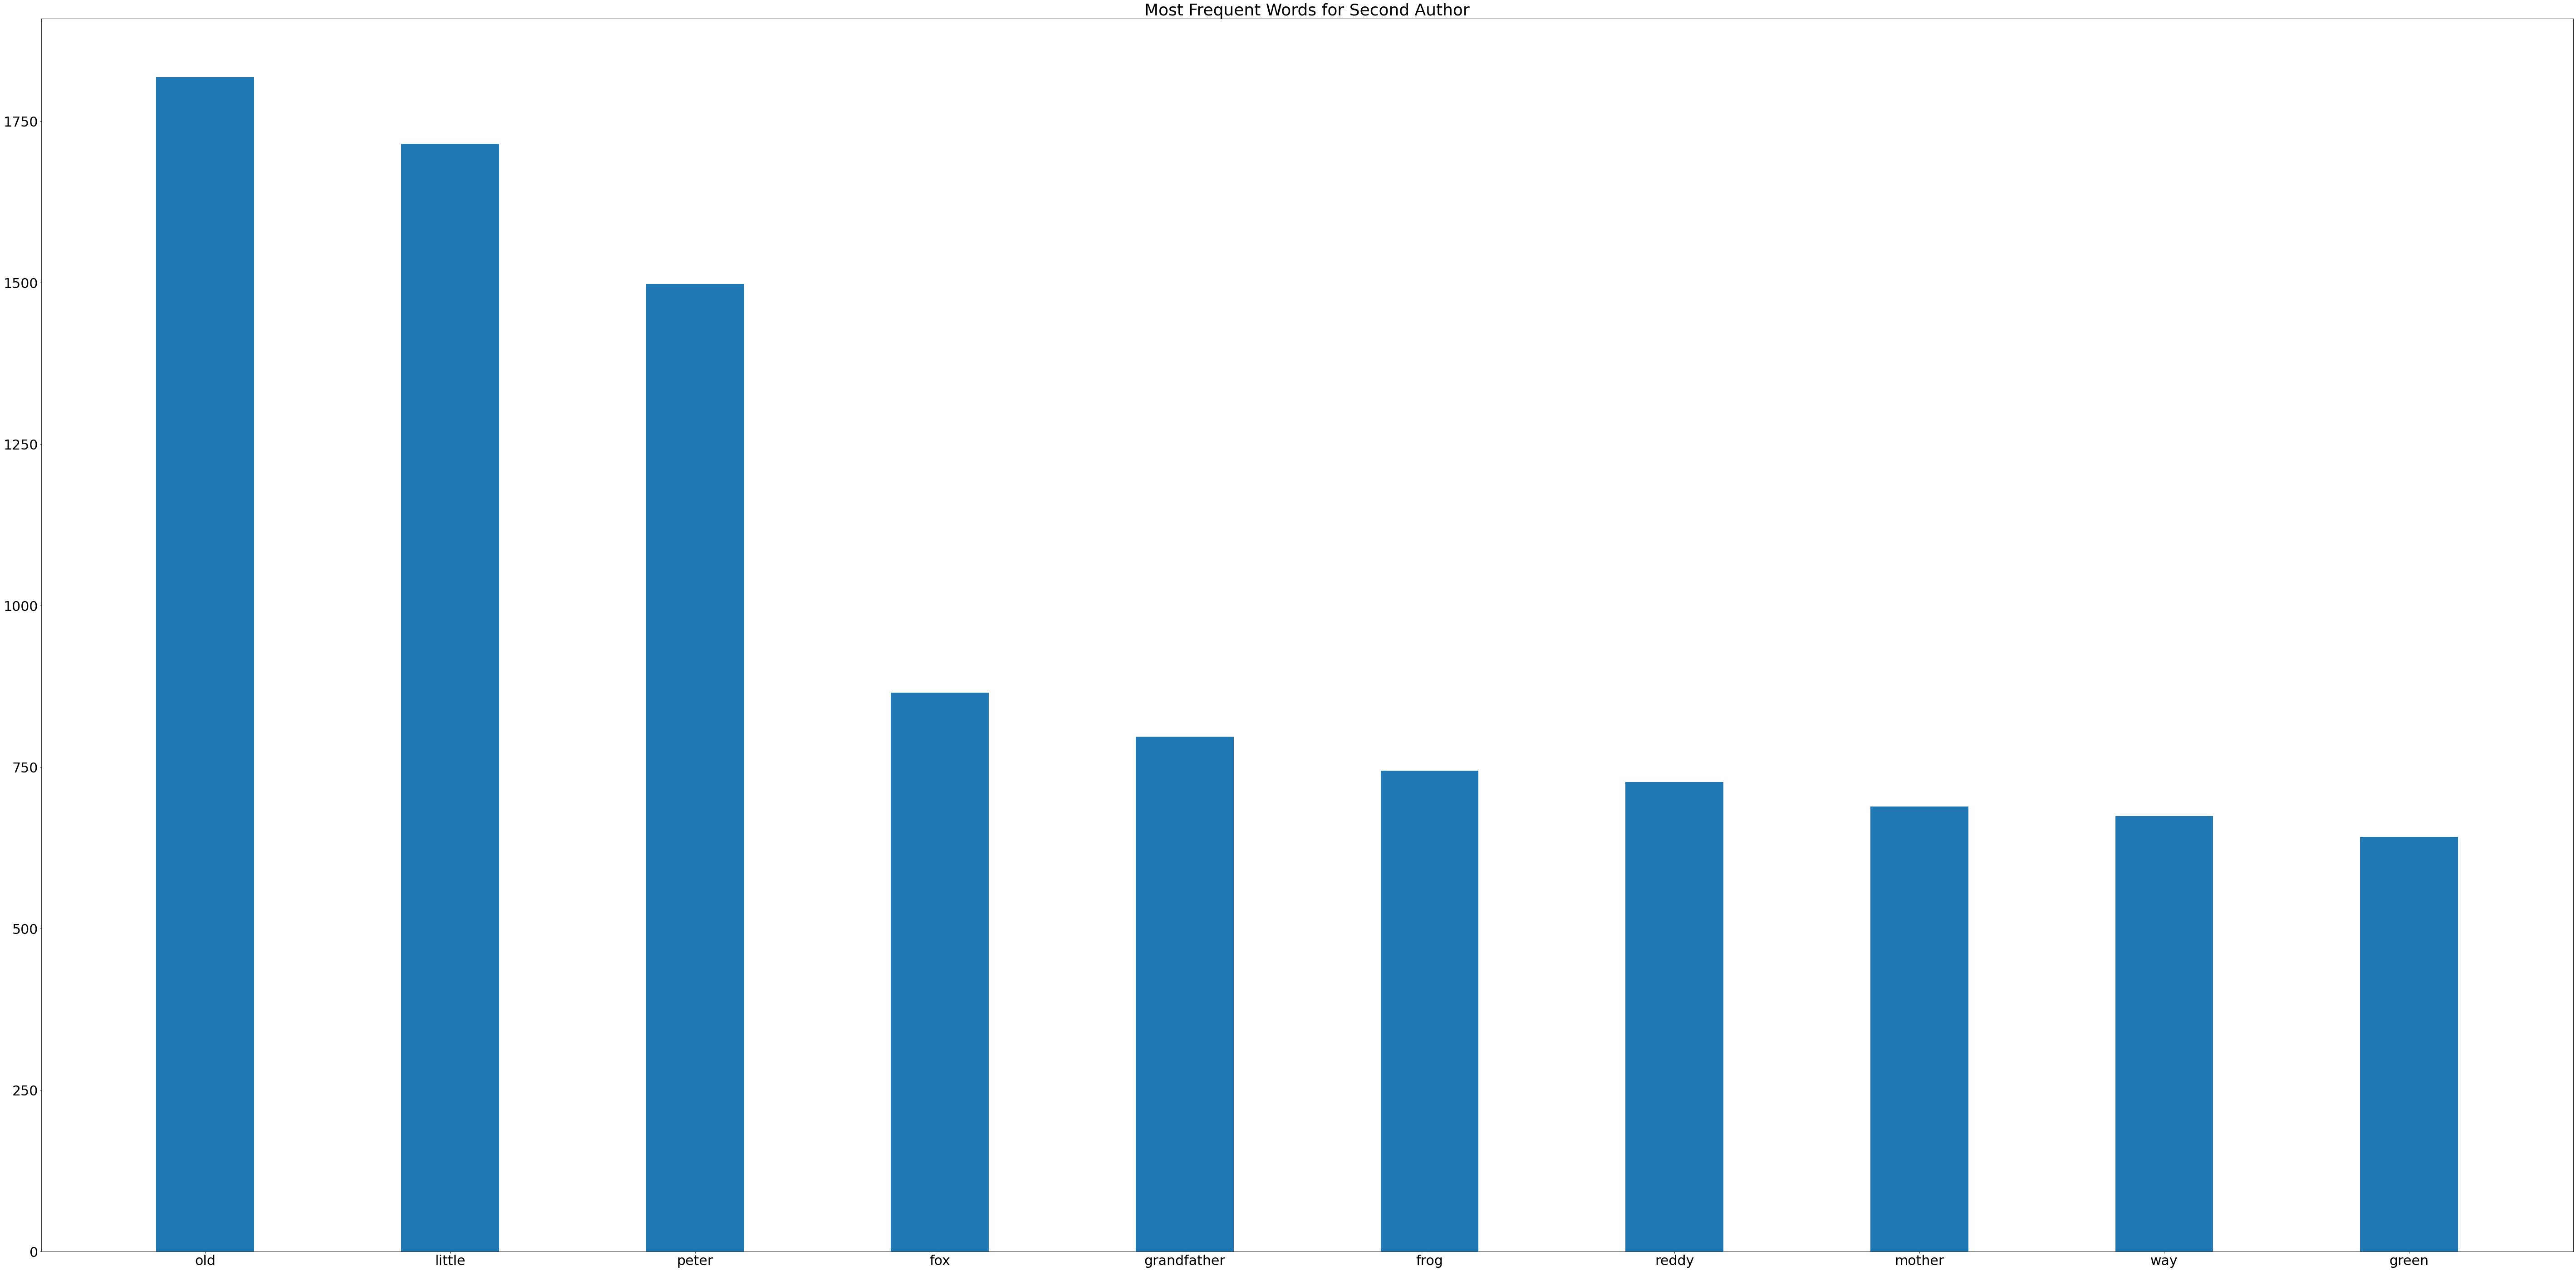

In [38]:
stopwords = stopwords
counter=0
file=[]

for x in rslt_df[0]:
    x=x.lower().split()
    file.append(x)
wordcount = collections.defaultdict(int)
pattern = r"\W"
for book in file:
    for word in book:
        word = re.sub(pattern, '', word)
        if word not in stopwords:
            wordcount[word] += 1            
print_top=10
mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:print_top]
mc = dict(mc)
names = list(mc.keys())
values = list(mc.values())
print(mc)
print()   

plt.rcParams["figure.figsize"] = (100,50)
plt.rcParams.update({'font.size': 30})
plt.bar(names, values, width = 0.4)
plt.title("Most Frequent Words for Second Author")
plt.show()

### Wordcloud of Author 2

Display a Wordcloud of all of the book titles from author 2, T.W. Thornton. This visualization is of *titles*  not all of his text. This is created for visualization purposes to see if we can easily spot theme and understand what his books are generally about.

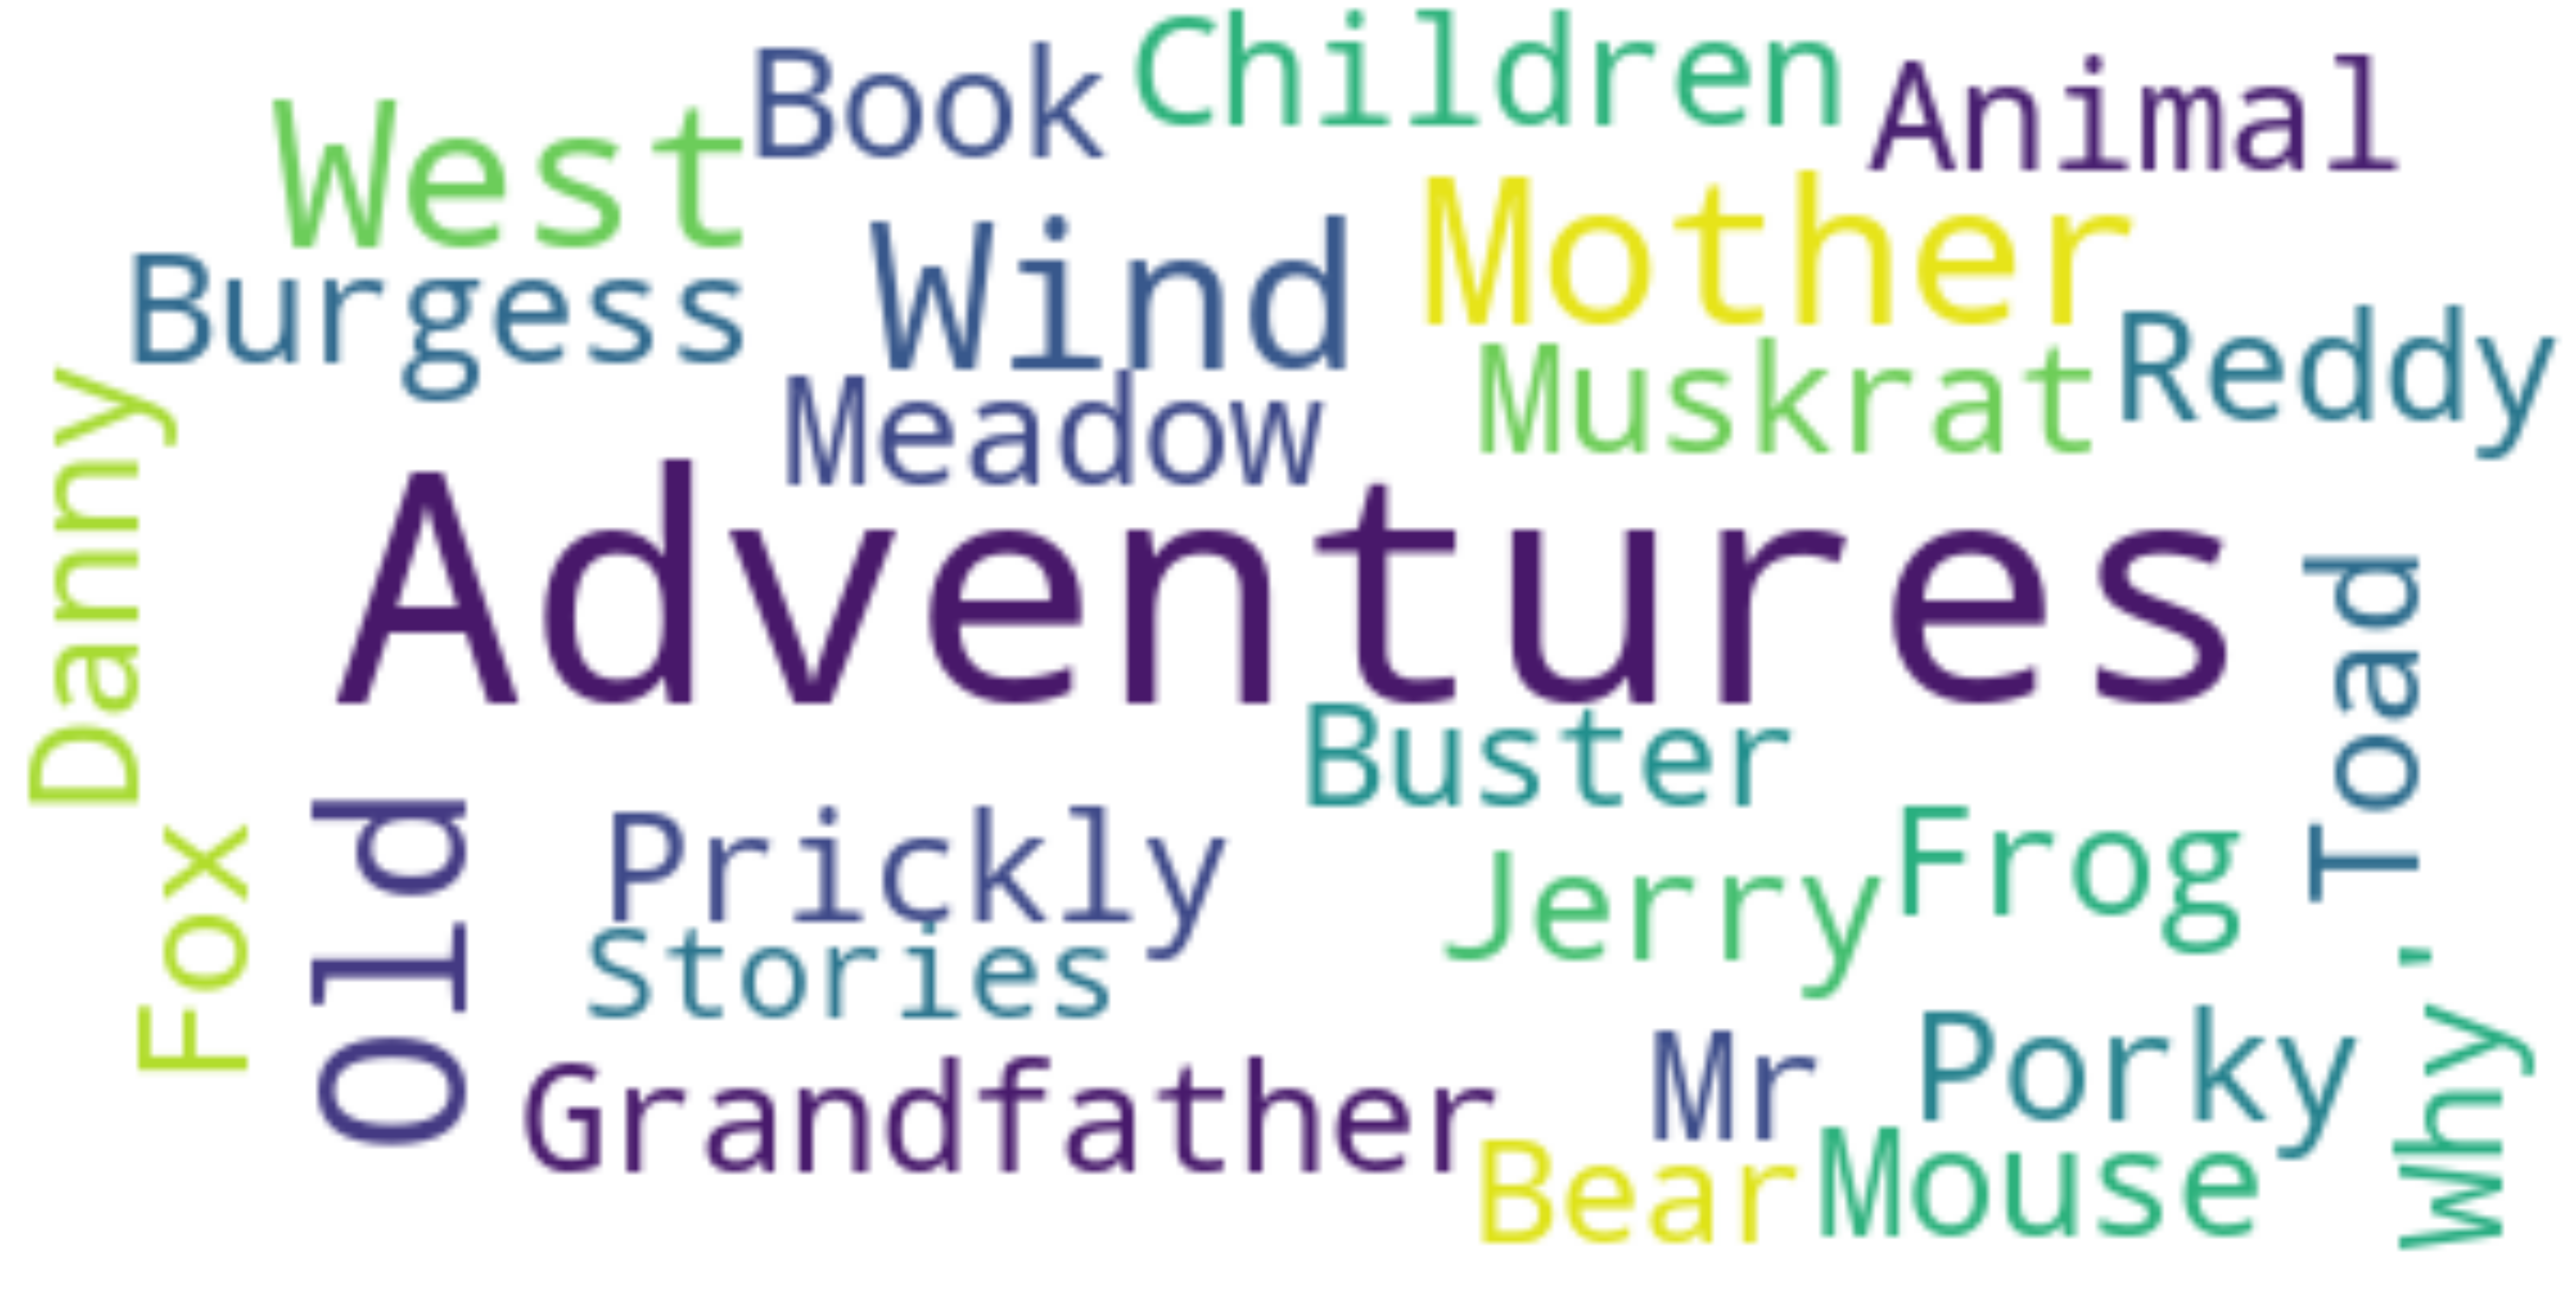

In [63]:
# T.W. Thornton Book Titles Wordcloud

text=" "
for file in rslt_df["Title"]:
    text += " "+file+" "
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# The Books
### Pre-Processing and Data Cleaning

The pre-processing and data cleaning was a two step iterative proccess. Basic pre-processing techniques were performed to clean the data, and custom stop words were added many times. This was a tedious process, and often times stop words had unlikely negative effects on topics when removed. By creating a function that looks for most frequent words in all of the books, you can clearly sse which words are important versus which are usless and thus, can be added to the stop words corpus.

In [57]:
# Automatically add the most frequent word to the system of stop words
# Manually modify this by looking at most frequent word in each story and see 
# if it is relevant or not

stopwords = stopwords+new_stop_words_list
counter=-1
'''
This function will loop through each book and find the most frequent words of every book,
so we can add them to our own list of stopwords. This helps analyze which words are 
important and which are useless.
'''

for x in book_names:
            counter=counter+1
            file = open(x, 'r', encoding="utf8")
            print('Book name ',x)
            print('Book Title',df_text['Title'].iloc[counter])
            print('Book Authour',df_text['Author'].iloc[counter])
            file = file.read()
            wordcount = collections.defaultdict(int)
            pattern = r"\W"
            # Remove text headers
            file = strip_headers(file).strip()
            # Convert text to lower case
            file=re.sub(r'\d+' ,'', file)
            # Remove punctuation from a string
            file = re.sub(r'[^\w\s]','',file)
            for word in file.lower().split():
                word = re.sub(pattern, '', word)
                if word not in stopwords:
                    wordcount[word] += 1
            article_length=len(file)
            #Top 20 words of each book 
            print_top=20
            mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:print_top]
            for word, count in mc:
                print(word, ":", count/article_length)
            mc = dict(mc)
            names = list(mc.keys())
            values = list(mc.values())
            print(mc)
            print()


Book name  pg14407.txt
Book Title The Tale Of Benjamin Bunny
Book Authour Beatrix Potter
peter : 0.002969561989606533
little : 0.002969561989606533
benjamin : 0.0026726057906458797
old : 0.0013363028953229399
bunny : 0.0011878247958426132
rabbit : 0.0011878247958426132
garden : 0.0011878247958426132
sat : 0.0010393466963622866
upon : 0.0010393466963622866
onions : 0.0010393466963622866
basket : 0.0010393466963622866
cat : 0.0010393466963622866
back : 0.0008908685968819599
top : 0.0008908685968819599
got : 0.0008908685968819599
took : 0.0008908685968819599
mcgregor : 0.0007423904974016332
pockethandkerchief : 0.0007423904974016332
wall : 0.0007423904974016332
wood : 0.0005939123979213066
{'peter': 20, 'little': 20, 'benjamin': 18, 'old': 9, 'bunny': 8, 'rabbit': 8, 'garden': 8, 'sat': 7, 'upon': 7, 'onions': 7, 'basket': 7, 'cat': 7, 'back': 6, 'top': 6, 'got': 6, 'took': 6, 'mcgregor': 5, 'pockethandkerchief': 5, 'wall': 5, 'wood': 4}

Book name  pg14375.txt
Book Title The Adventures o

In [40]:
# Ran through pre-processing basics again

counter=0
for x in df_text[0]:
    # Remove text headers
    x = strip_headers(x).strip()
    # Convert text to lower case
    x=x.lower()
    # Remove white Spaces
    x=x.strip()
    # Remove numbers
    x=re.sub(r'\d+' ,'', x)
    # Remove punctuation from a string
    x = re.sub(r'[^\w\s]','',x)
    #
    df_text[0].iloc[counter]=x
    counter=counter+1

In [44]:
# Rename column

df_text = df_text.rename(columns={0: 'Text'})
df_text

Text  \
0    proofreading team\n\n\n\n\n\n\nillustration\n\...   
1    hutchinson and the project gutenberg online di...   
2    the boy mechanic\nvol \n things for boys to do...   
3    note project gutenberg also has an html versio...   
4    proofreading teamhttpswwwpgdpnet\n\n\n\n\n\n\n...   
..                                                 ...   
114  the children of odin\nthe book of northern myt...   
115  fairy tales of hans christian andersen\n\n\n\n...   
116  illustration mrs tittlemouse  bees\n\n\n\n\nth...   
117  more russian picture tales\n\nillustration\n\n...   
118  online distributed proofreading team at httpsw...   

                                      Title                   Author  \
0                The Tale Of Benjamin Bunny           Beatrix Potter   
1        The Adventures of Grandfather Frog      Thornton W. Burgess   
2                The Boy Mechanic: Volume 1        Popular Mechanics   
3                     The Cat and the Mouse                            
4             The Tale of Mrs. Tiggy-Winkle           Beatrix Potter   
..                                      ...                      ...   
114                    The Children of Odin            Padraic Colum   
115  Fairy Tales of Hans Christian Andersen  Hans Christian Andersen   
116            The Tale of Mrs. Tittlemouse           Beatrix Potter   
117              More Russian Picture Tales           Valery Carrick   
118                   Roumanian Fairy Tales                  Various   

                          Release Date  
0     December 21, 2004 [EBook #14407]  
1    December 17, 2004  [eBook #14375]  
2         June 18, 2004 [EBook #12655]  
3     January 31, 2008  [eBook #24473]  
4     February 22, 2005 [EBook #15137]  
..                                 ...  
114       March 2, 2008 [EBook #24737]  
115    November 8, 2008 [EBook #27200]  
116   November 18, 2005 [EBook #17089]  
117   November 12, 2007 [EBook #23462]  
118   February 10, 2007 [EBook #20552]  

[119 rows x 4 columns]

# Topic Modeling

To begin the topic modeling of our dataframe, we will set our parameters in order to display the top 20 words in 10 topics. Then, we will perform NMF and LDA topic modeling to see which process yeilds better topic results.  

In [45]:
# Number of parameters for modeling

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20

In [46]:
# Write function to display models

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [47]:
# Data into array

data_samples=[]
for x in df_text["Text"]:
    data_samples.append(x)

## NMF Modeling

As displayed below, the NMF model is ultimately our winner. It is much more intrepretable and gives us relatively good and understandable topics.

### TfidfVectorizer

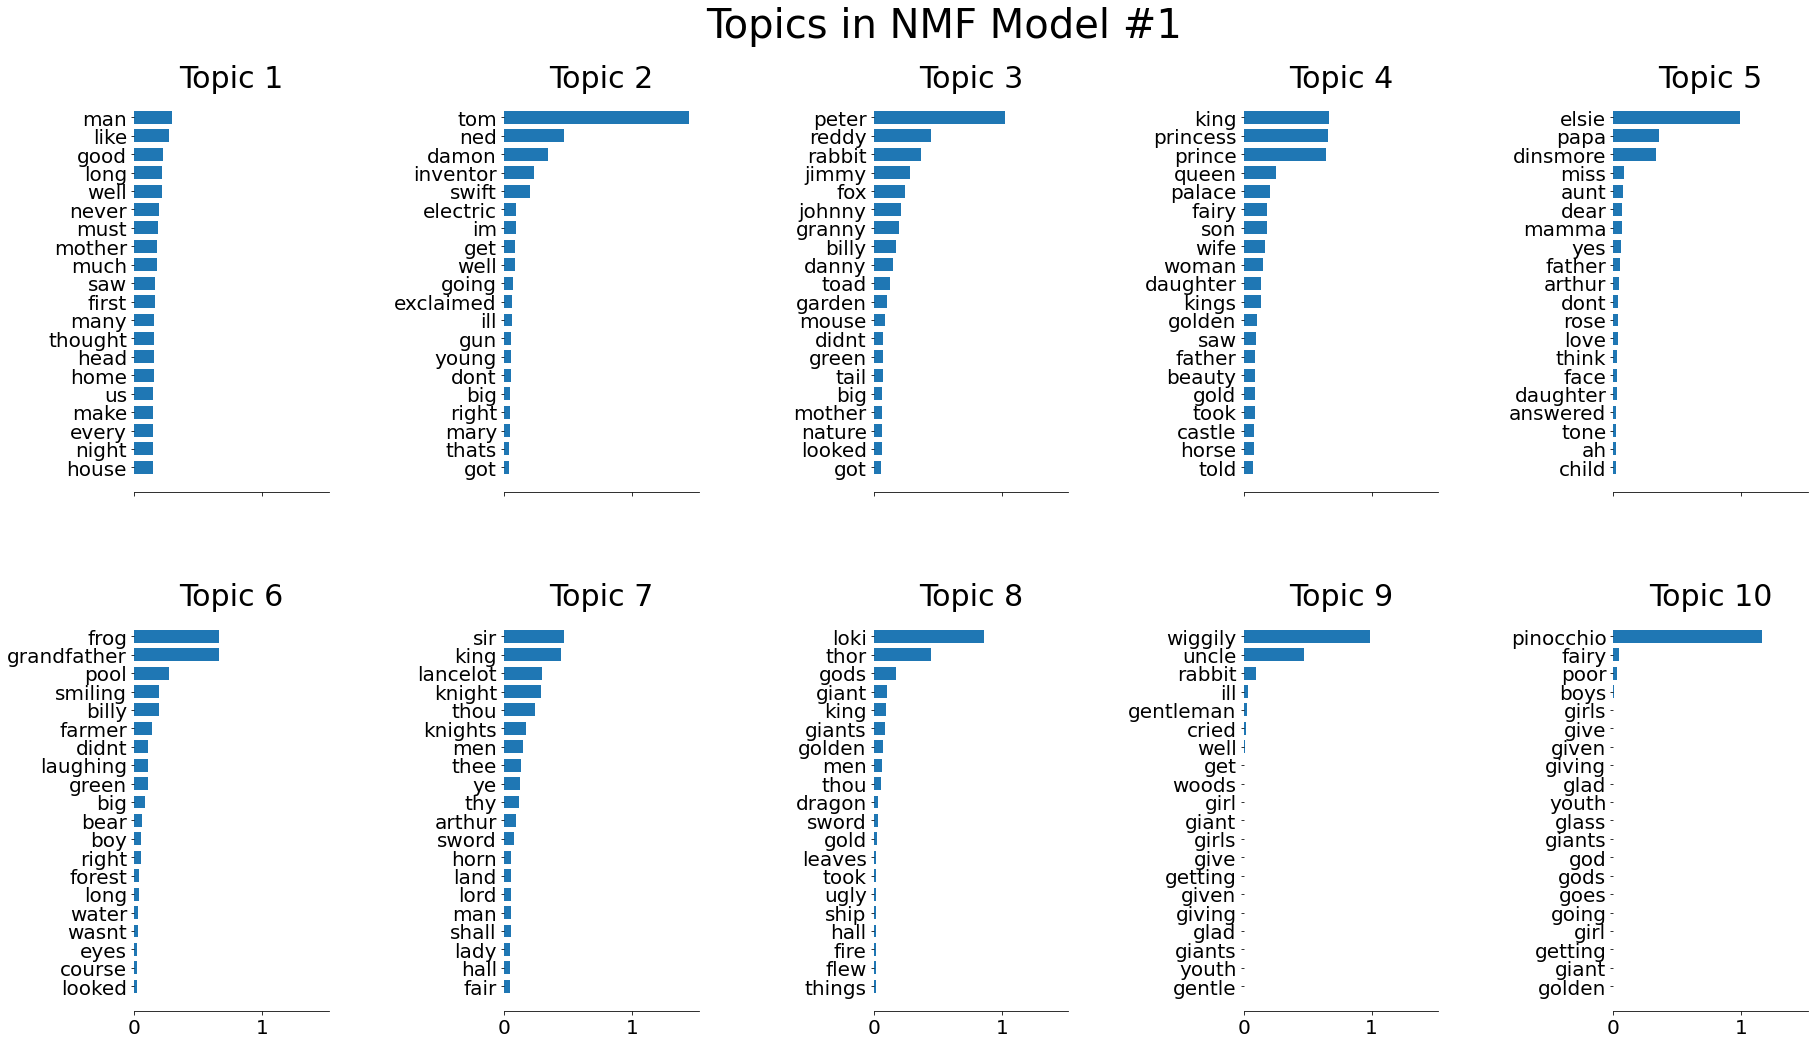

In [59]:
# Begin the modeling process
# Use tfidf features for NMF

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=n_features,stop_words=stopwords)
tfidf_matrix = tfidf_vectorizer.fit_transform(data_samples)
tfidf_matrix.shape
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
nmf = NMF(n_components=n_components, random_state=1,alpha=.1, l1_ratio=.5).fit(tfidf_matrix)
plot_top_words(nmf, tfidf_feature_names, n_top_words,'Topics in NMF Model #1')

### CountVectorizer

In [60]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,max_features=n_features,stop_words='english')
tf = tf_vectorizer.fit_transform(data_samples)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

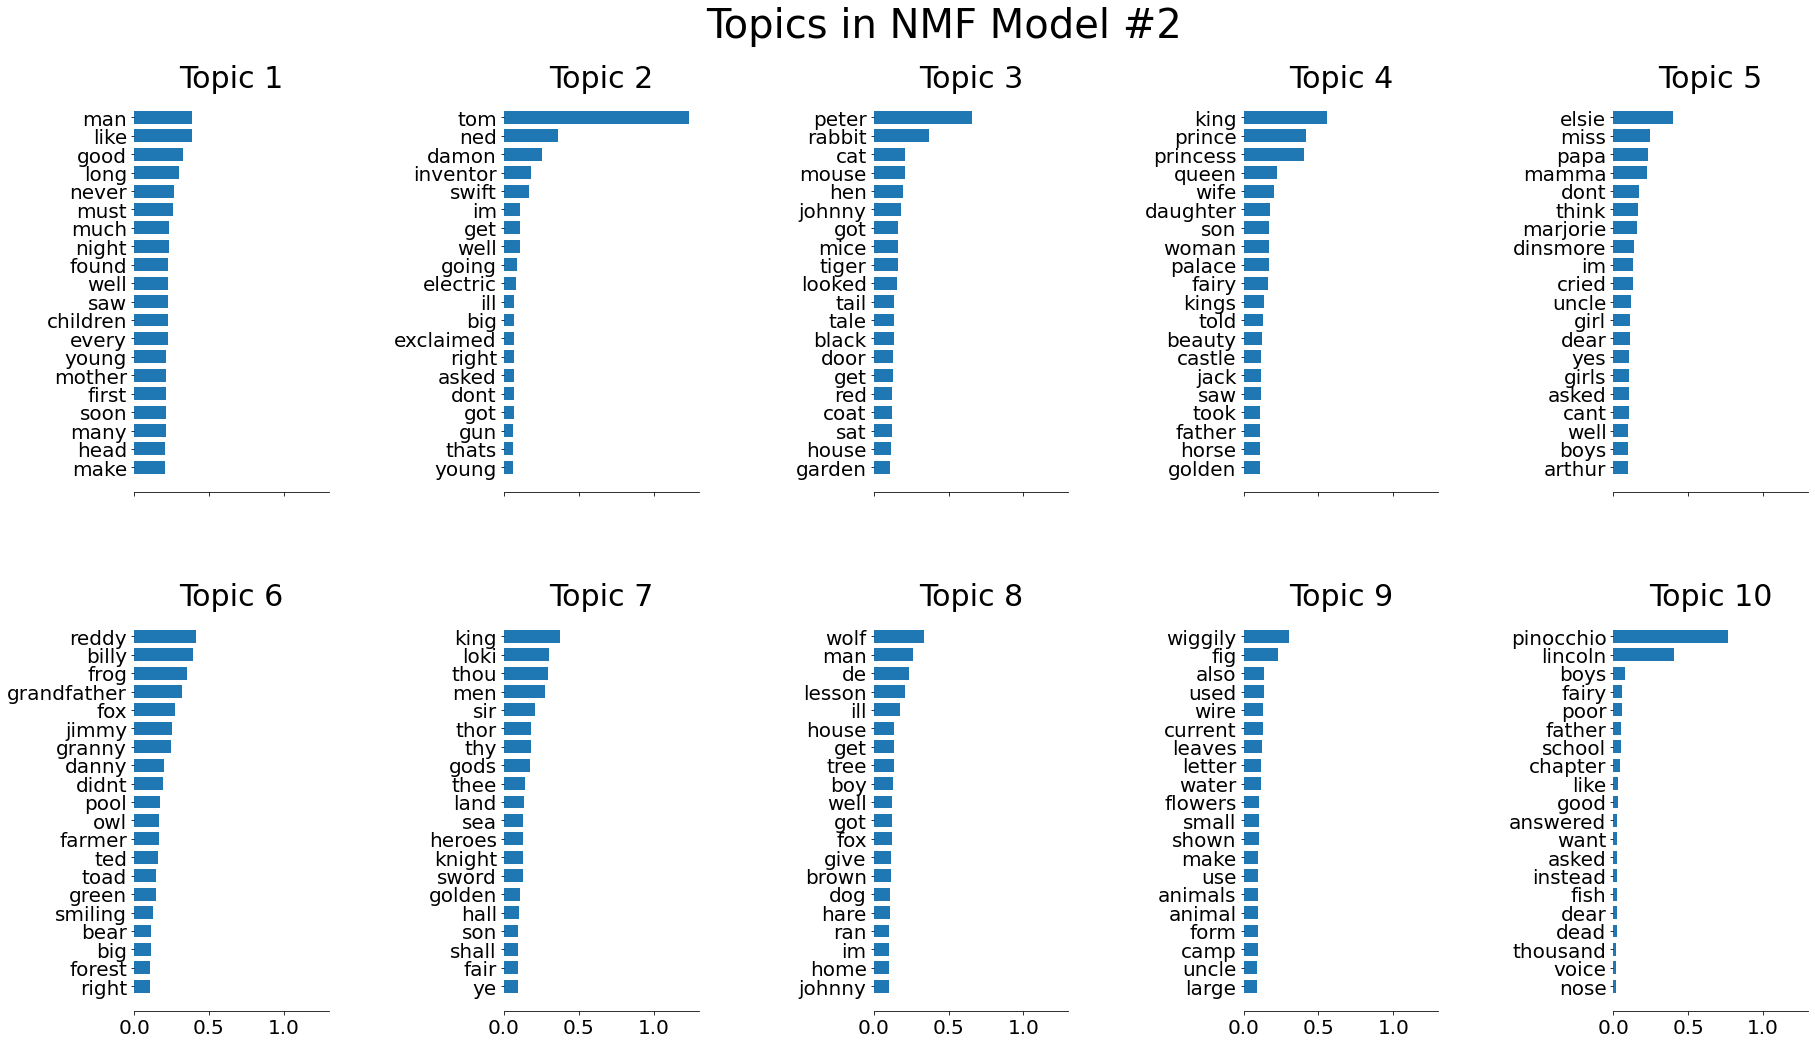

In [61]:
# add a beta- loss element
# get better topics, more clear results
nmf = NMF(n_components=n_components, random_state=1,beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,l1_ratio=.5).fit(tfidf)
plot_top_words(nmf, tfidf_feature_names, n_top_words,'Topics in NMF Model #2')

### My Final Topics

Based on the NMF modeling, the top 5 topics for our data is listd below. CountVctorizer and TfidfVectorizers were both performed and gave similar results. Ultimately, the topics were chosen based on NMF Model #1, using TfidfVectorizer. Since it normalizes the count, and we are focusing on term frequency this is an obvious choice.

Topics:
1. Nature and Outdoors
    - frog, pool, smiling, farmer
2. Animals
    - rabbit, garden, cat, mouse
3. Mythical Creatures
    - gods, giants, dragons, swords
4. Fairy Tales
    - knight, sword, lady, lord
5. Family and Relationships
    - papa, mama, aunt dear
 

### LDA Modeling

LDA topic modeling is performed to see if this model produces better results of our topics. Then, we can compare the NMF and LDA models. As we will see, this model is less inerpretable and produces topics that are much more unclear than the NMF model.  

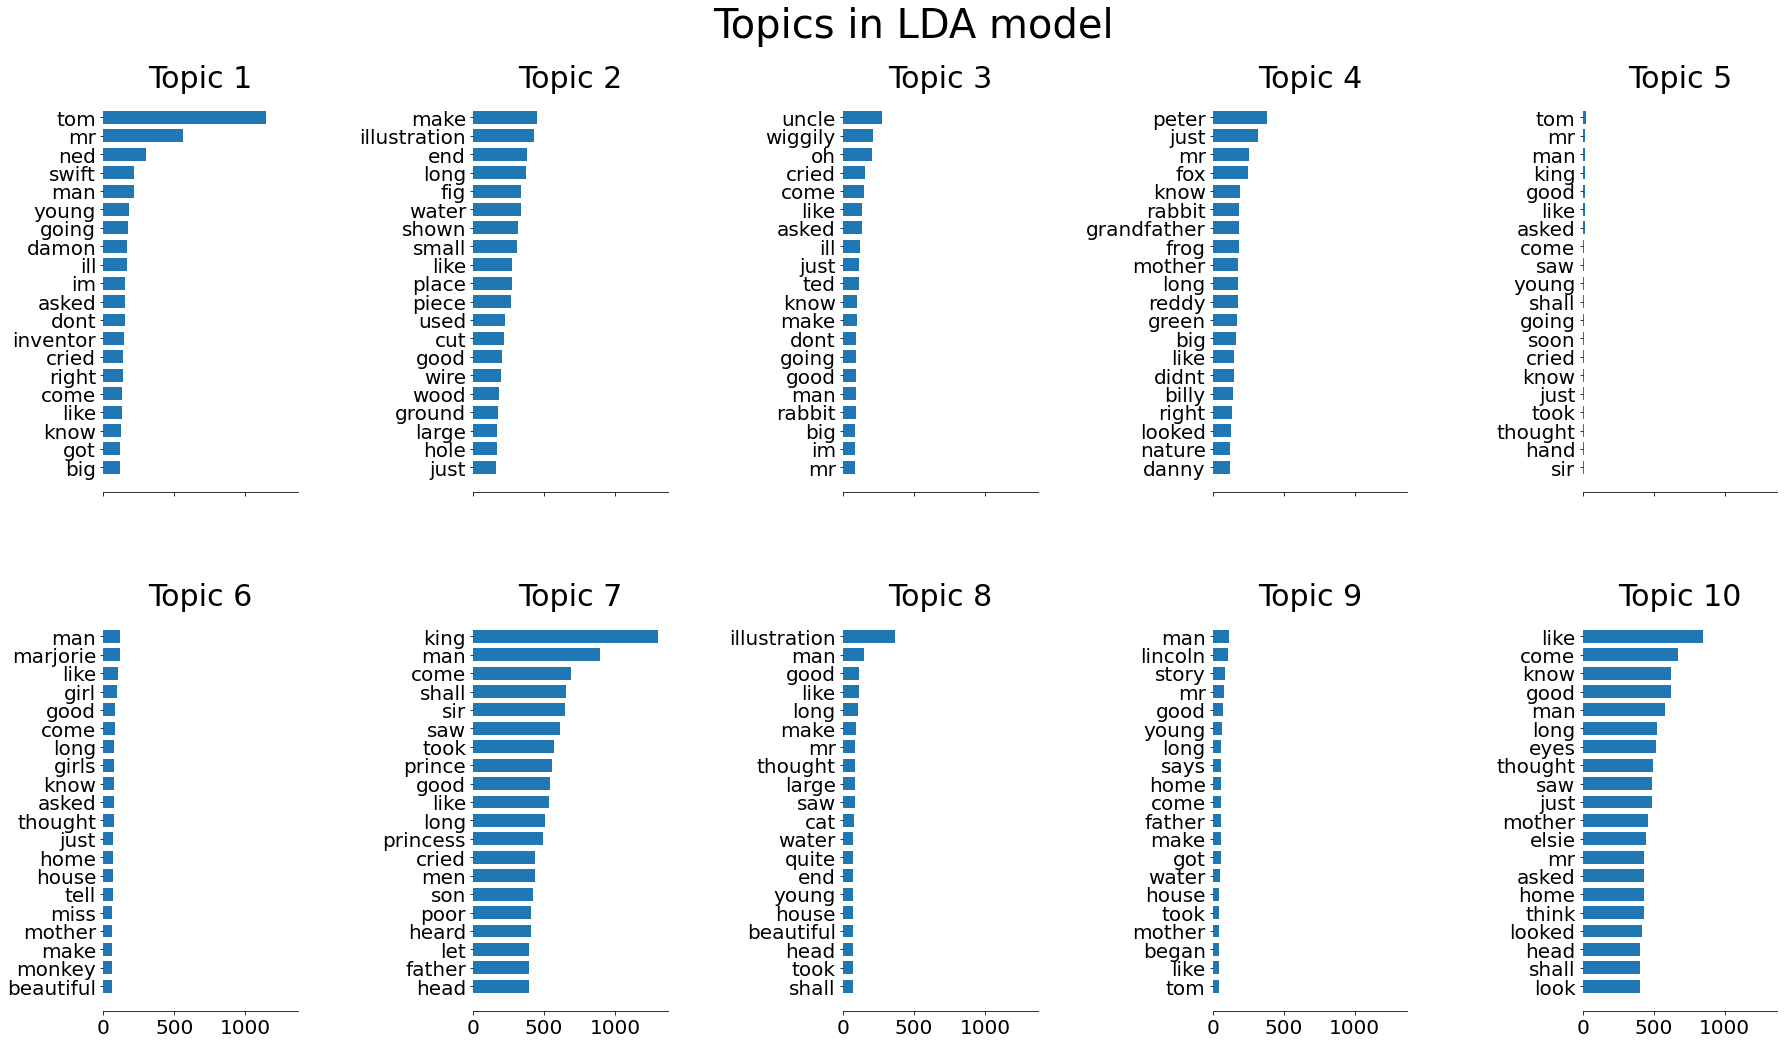

In [52]:
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,learning_method='online',learning_offset=50.,random_state=0)
lda.fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

# Extras:
## Recommendations 
#### Tools used for finding books based on topic, NOT proper recommendation system

Now, that we have our clear and well defined topics, as well as what the top words are within those topics, I would like to easily find books similar to these topics. As a precursor to making a proper recommendation system, the following code will help make a simple book recommendation based on the given topics. There are 5 topics to choose from, which is a good representation of the themes throughout our entire book dataset. By choosing a topic you would like a book for, you can easily input this topic and get results that are books related to that topic. 

The next block of code is interactive, you can enter the number of the topic you want to look at.

In [75]:
# Picking choices based on 5 main topics
# Here are my five main topics and the top 4 topic words associated to each
# Here you can input a topic 1-5 that you want to see recommendations for. 
# **Recs are based on frquency of words in chosen topic**


Nature_and_outdoors=['frog','pool','smiling','farmer']
Animals = ['rabbit','garden','cat','mouse']
Mythical_Creatures=['gods','giants','dragons','swords']
Fairy_Tales=['knight','sword','lady','lord']
Family_and_Relationships=['papa','mama','aunt','dear']
input_number=int(input("Please Enter Topic Number: 1.Nature and Outdoors   2.Animals    3.Mythical Creatures   4.Fairy Tales    5.Family and Relationships :"))
if(input_number==1):
    used_array=Nature_and_outdoors
elif(input_number==2):
    used_array=Animals
elif(input_number==3):
    used_array=Mythical_Creatures
elif(input_number==4):
    used_array=Fairy_Tales  
elif(input_number==5):
    used_array=Family_and_Relationships
else:
    print('Wrong Number was entered')

Please Enter Topic Number: 1.Nature and Outdoors   2.Animals    3.Mythical Creatures   4.Fairy Tales    5.Family and Relationships : 3


### Plotting Distributions of Topic Words Across All Books

This function will process all of the books for the given topic and loop through them all searching for the main topic words. The visualization represents the distribution of each topic word among every book that is in the main topic. 

In [73]:
# After initializing my list of topics and the elements that appear in each,
# a function was created that will take used arrays and connect them to a given
# topic. Each topic is set to a used_array. Similar to function above,
# this will be counting how mamny times a topic is present in a book.

counter=-1
First_value=[]
Second_value=[]
Third_value =[]
Fourth_value=[]
for x in book_names:
            used_array_num=[0] * len(used_array)
            counter=counter+1
            file = open(x, 'r', encoding="utf8")
            print('Processing Book name :',x)
            print()
            file = file.read()
            wordcount = collections.defaultdict(int)
            pattern = r"\W"
            file = strip_headers(file).strip()
            file=re.sub(r'\d+' ,'', file)
            file = re.sub(r'[^\w\s]','',file)
            for word in file.lower().split():
                word = re.sub(pattern, '', word) 
                if word in used_array:
                    wordcount[word] += 1
                    used_array_num[used_array.index(word)]=used_array_num[used_array.index(word)]+1
            article_length=len(file)
            to_print=4
            mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print]
            mc = dict(mc)
            names = list(mc.keys())
            values = list(mc.values())
            First_value.append(used_array_num[0])
            Second_value.append(used_array_num[1])
            Third_value.append(used_array_num[2])
            Fourth_value.append(used_array_num[3])


Processing Book name : pg14407.txt

Processing Book name : pg14375.txt

Processing Book name : 12655-0.txt

Processing Book name : pg24473.txt

Processing Book name : pg15137.txt

Processing Book name : pg12116.txt

Processing Book name : 52521-0.txt

Processing Book name : pg20748.txt

Processing Book name : pg24248.txt

Processing Book name : pg14837.txt

Processing Book name : pg15281.txt

Processing Book name : pg582.txt

Processing Book name : pg15040.txt

Processing Book name : pg19068.txt

Processing Book name : pg21078.txt

Processing Book name : pg14766.txt

Processing Book name : pg22766.txt

Processing Book name : pg29021.txt

Processing Book name : pg24263.txt

Processing Book name : pg18767.txt

Processing Book name : 22373-0.txt

Processing Book name : pg15284.txt

Processing Book name : pg15521.txt

Processing Book name : pg11592.txt

Processing Book name : pg24676.txt

Processing Book name : pg17135.txt

Processing Book name : pg13347.txt

Processing Book name : pg24714

### Visualization
This graph displays the distribution of the 4 topic words associated to the corresponding topic, as described above. Here we see the topic 'Mythical Creatures' and how often its topic words, 'gods, giants, dragons, swords,' appear in each book. This looks across all 120 books, and the are empty spaces mean that topic wasn't present. 

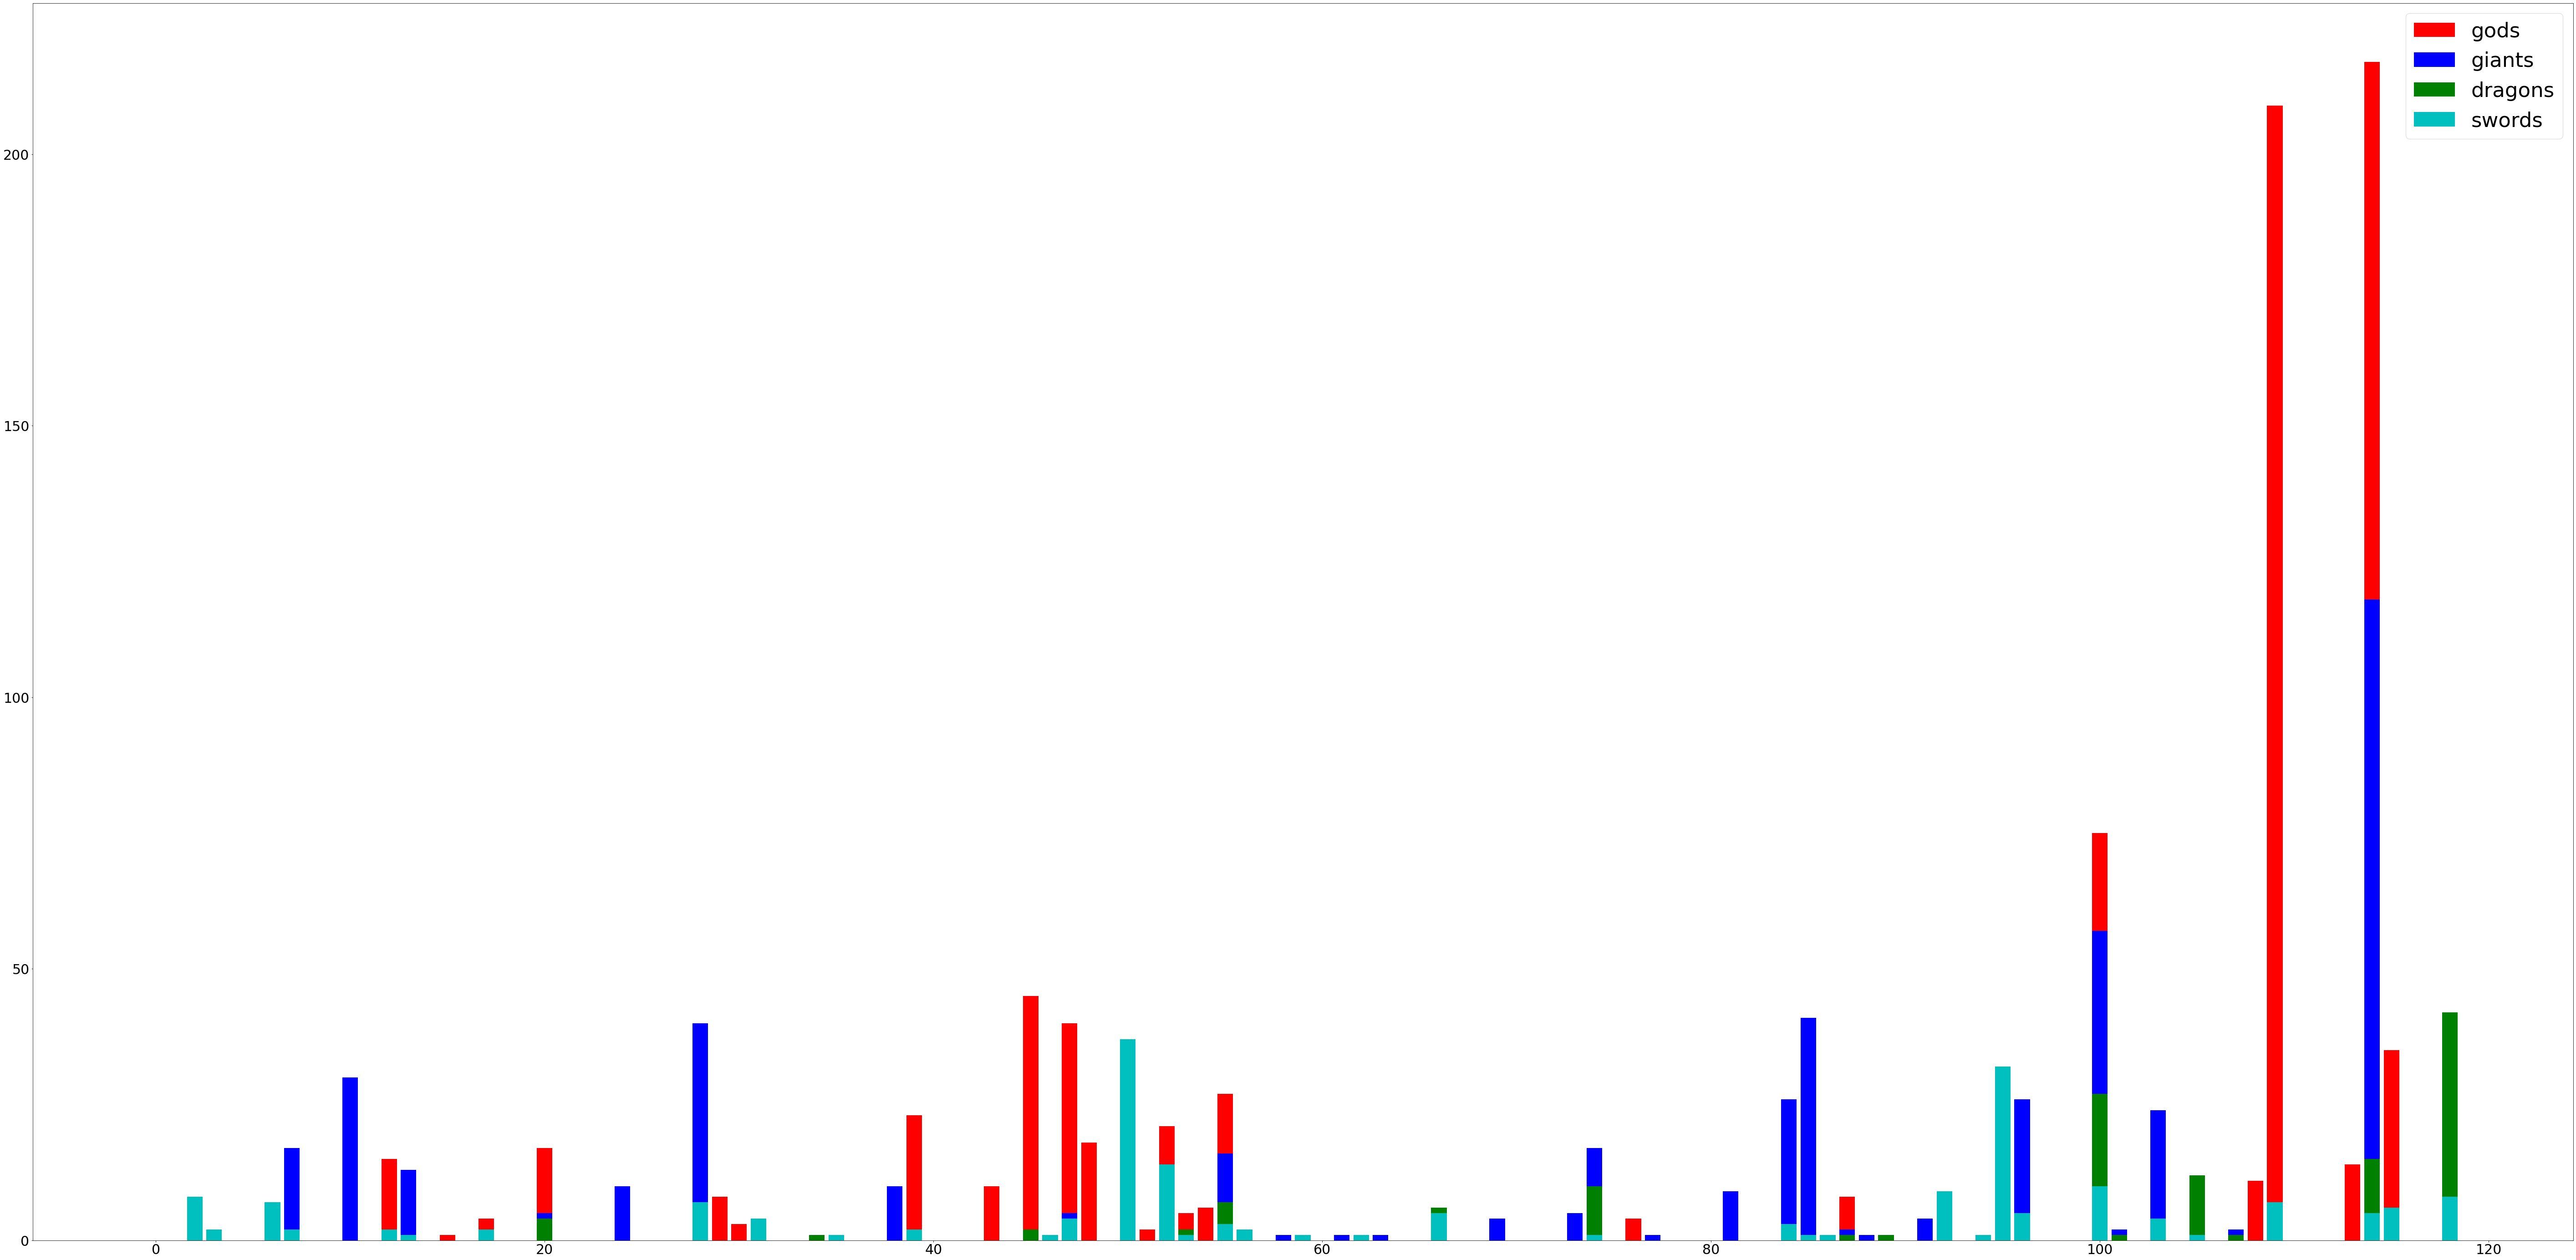

In [74]:
# The visualization shows a graph of the distributions
# of each topics defined topic words, depending on which topic you choose.
# The four colors show how many of each parameter is present
# in each book, across all books. Each bar is a book, if empty space 
# that means there was nothing presnt there.

x_bins = list(df_text.index) 
width = 0.8
p1 = plt.bar(x_bins, First_value, width, color='r')
p2 = plt.bar(x_bins, Second_value, width, color='b')
p3 = plt.bar(x_bins, Third_value, width, color='g')
p4 = plt.bar(x_bins, Fourth_value, width,color='c')
plt.legend((p1[0], p2[0], p3[0],p4[0]), (used_array[0], used_array[1], used_array[2], used_array[3]), prop={'size': 45})
plt.show()

### Simple Recommender

In conjunction with the above code, we were able to input a topic of your choice, which then generates where those books are present in our data. These next steps, aim to produce the actual book titles so that a reader can find them and enjoy! This is a version of a simple 'recommender' that will provide a book recommendation based on the most frequent words in that given topic that you want. The goal is to be able to ask for books about 'Mythical Creatures,' and get those book titles that are about mythical creatures. 

In [ ]:
# I created a simple recommender that chooses books based on
# a chosen topic. This function processes the books in the same way
# as above, and sums up all the words in the topics, recommending/displaying 
# the top 2 books with the highest amount of associated words in that topic.


counter=-1
sum_value=[]
counter=-1
for x in book_names:
            used_array_num=[0] * len(used_array)
            counter=counter+1
            file = open(x, 'r', encoding="utf8")
            print('Processing Book name :',x)
            file = file.read()
            wordcount = collections.defaultdict(int)
            pattern = r"\W"
            file = strip_headers(file).strip()
            file=re.sub(r'\d+' ,'', file)
            file = re.sub(r'[^\w\s]','',file)
            for word in file.lower().split():
                word = re.sub(pattern, '', word)
                if word in used_array:
                    wordcount[word] += 1
                    used_array_num[used_array.index(word)]=used_array_num[used_array.index(word)]+1
            article_length=len(file)
            to_print=4
            mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print]
            mc = dict(mc)
            names = list(mc.keys())
            values = list(mc.values())
            sum_value.append(sum(used_array_num))

### Display the top 2 Recommended Books
This displays the top 2 books of which ever topic was chosen. More work needs to be done to make it work beoyond just the topics and handle more specific requests. This is a very simple version and a starting point for future next steps. 

In [72]:
# Display the top 2 recommended books
# These are the top 2 recommended books for 'Mythical Creatures'

import numpy as np
top_idx = np.argsort(sum_value)[-2:]
top_2_values = [sum_value[i] for i in top_idx]
counter=1
for x in  reversed(top_2_values):
    temp= sum_value.index(x)
    print("{}.".format(counter),df_text['Title'].iloc[temp])
    counter=counter+1
#print(sum_value.index(top_2_values[1]))

1. The Children of Odin
2. A Book of Myths


# The End!